In [1]:
import re
import os

import numpy as np

from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.variables import Variables

import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import seaborn as sns
from pprint import pprint

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

In [2]:
%matplotlib inline

def SAVEFIG(fig, filename, path=None, formats=('png', 'pdf', 'jpg', 'tiff')):
    local_path = f'.' if path is None else path

    fileout = f"{local_path}/{filename}".replace("\n", " ").replace(">", " ").replace("<", " ")
    for my_format in formats:
        if my_format in ['png', 'jpg', 'tiff']:
            fig.savefig(f"{fileout}.{my_format}", format=my_format, bbox_inches="tight", dpi=300)
        else:
            fig.savefig(f"{fileout}.{my_format}", format=my_format, bbox_inches="tight")
    return fig, tuple(f'{fileout}.{fmt}' for fmt in formats)

In [3]:
verbose = False

Shell.mkdir('./images')
log_dir = "../experiments/rivanna/localscratch"
notebook = Shell.map_filename(f"{log_dir}/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/cloudmesh_mllog.log").path
name_of_gpu = 'A100'

# print ("NOTEBOOK", notebook)
# os.system(f"ls {notebook}")

mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [4]:
fixed_dicts = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    # print('d', working_line)
    # print(type(working_line))

    # interpreting scientific values
    parse_line = working_line['value']['extrastring']
    parse_list = parse_line.split()

    # this function returns the value after a specified word
    def looking_for(seeking_value: str):
        found_it = False
        for word in parse_list:
            if found_it:
                return word
            if word == seeking_value:
                found_it = True
                continue

    validation_value = looking_for('Validation')
    if validation_value:
        working_line['value']['validation'] = validation_value
    training_value = looking_for('Training')
    if training_value:
        working_line['value']['training'] = training_value

    list_of_values = []
    working_line['value']['MSE'] = {}
    for word in parse_list:
        if '=' in word and ('F' in word or 'S' in word or 'E' in word):
            temp_word = word.split('=')
            working_line['value']['MSE'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
    working_line['value']['title'] = working_line['key']
    working_line['key'] = 'result'

    program_title = looking_for('UTC')
    working_line['value']['program'] = program_title
    nnse = looking_for('summedErr/SummedObs')
    working_line['value']['NNSE'] = nnse
    comment = looking_for('TOTAL')
    working_line['value']['comment'] = comment

    future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
    try:
        working_line['value']['future'] = future.group(1)
    except AttributeError:
        pass

    loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
    working_line['value']['location_summed_results'] = loc_sum.group(1)
    del working_line['value']['extrastring']

    fixed_dicts.append(working_line)


In [5]:
if verbose:

    for fixed_dict in fixed_dicts:
        pprint(fixed_dict)
    print(len(fixed_dicts))
        # print(working_line)


In [6]:
list_of_value_dicts_training = []
list_of_value_dicts_validation = []
fails = 0
for dictionary in fixed_dicts:
    # try:
    #     if dictionary['value']['training']:
    #         list_of_value_dicts_training.append(dictionary['value'])
    # except KeyError:
    #     list_of_value_dicts_validation.append(dictionary['value'])
    if dictionary.get('value', None).get('training', None):
        list_of_value_dicts_training.append(dictionary['value'])
    elif dictionary.get('value', None).get('validation', None):
        list_of_value_dicts_validation.append(dictionary['value'])
    else:
        fails += 1
print('fails:', fails)
    #list_of_value_dicts.append(dictionary['value'])

for iterated_dictionary in list_of_value_dicts_training:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']

for iterated_dictionary in list_of_value_dicts_validation:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']



fails: 0


In [7]:
df_training = pd.DataFrame(list_of_value_dicts_training)
df_validation = pd.DataFrame(list_of_value_dicts_validation)

df_training.drop('MSE', axis=1, inplace=True)
df_validation.drop('MSE', axis=1, inplace=True)

df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

dataframes = [df_training, df_validation]

for dataframe in dataframes:
    for index, row in dataframe.iterrows():
        dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

        if dataframe.loc[index, 'future'] is np.nan:
            temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
            remove_words = ['Magnitude', 'Mag']
            for word in remove_words:
                if word in temp_string_list:
                    temp_string_list.remove(word)
            new_string = " ".join(temp_string_list)
            dataframe.loc[index, 'name'] = new_string

        else:
            added_string = ''
            temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
            if 'Months' in temp_string_list:
                if '6' in temp_string_list:
                    added_string = '6M '
                elif '3' in temp_string_list:
                    added_string = '3M '
            elif 'Year' in temp_string_list:
                added_string = '1Y '
            elif '2' in temp_string_list and 'weeks' in temp_string_list and 'Now' in temp_string_list:
                added_string = 'Now '
            dataframe.loc[index, 'name'] = added_string + dataframe.loc[index, 'future'].split()[-1]
    dataframe.sort_values('NNSE', inplace=True)


    dataframe.pop("NNSEpercent")
    last = len(df_training.keys()) -1
    DELETE = -1000

    for index, what in [(0, 'name'),
                        (1,"NNSE"),
                        (DELETE, "location_summed_results"),
                        (DELETE, "comment"),
                        (DELETE, "title"),
                        (DELETE, "program"),
                        (DELETE, "future")]:
        col = dataframe.pop(what)
        if index != DELETE:
            dataframe.insert(index, what, col)



In [8]:
display(df_training)

,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV
2,6 Months Back,0.1556,0.68565,0.608,0.607,0.777,0.772,0.00517,0.005806,0.004412,NaN,NaN
6,6M 2wk+7AVG,0.1639,0.68565,0.608,0.607,0.777,0.772,0.006861,0.007551,0.006033,NaN,NaN
10,6M 2wk+13AVG,0.1709,0.68565,0.608,0.607,0.777,0.772,0.00836,0.009171,0.007379,NaN,NaN
1,3 Months Back,0.1764,0.68565,0.499,NaN,0.588,NaN,0.004899,0.005172,0.004574,0.504,0.636
5,3M 2wk+7AVG,0.1999,0.68565,0.499,NaN,0.588,NaN,0.006762,0.007079,0.006382,0.504,0.636
14,6M 2wk+26AVG,0.2033,0.68565,0.608,0.607,0.777,0.772,0.008773,0.009367,0.008043,NaN,NaN
3,Year Back,0.2182,0.68565,0.608,NaN,0.777,NaN,0.006657,0.007491,0.005664,0.612,0.775
7,1Y 2wk+7AVG,0.2235,0.68565,0.608,NaN,0.777,NaN,0.00693,0.007492,0.006255,0.612,0.775
9,3M 2wk+13AVG,0.2254,0.68565,0.499,NaN,0.588,NaN,0.007017,0.007324,0.006645,0.504,0.636
11,1Y 2wk+13AVG,0.2258,0.68565,0.608,NaN,0.777,NaN,0.008292,0.009364,0.006996,0.612,0.775


In [9]:
display(df_validation)

,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV
2,6 Months Back,0.1626,0.70036,0.608,0.607,0.777,0.772,0.005303,0.006081,0.004375,NaN,NaN
1,3 Months Back,0.1741,0.70036,0.499,NaN,0.588,NaN,0.004938,0.005407,0.004379,0.504,0.636
10,6M 2wk+13AVG,0.1805,0.70036,0.608,0.607,0.777,0.772,0.008281,0.009349,0.006989,NaN,NaN
6,6M 2wk+7AVG,0.1816,0.70036,0.608,0.607,0.777,0.772,0.006934,0.007764,0.005938,NaN,NaN
5,3M 2wk+7AVG,0.1944,0.70036,0.499,NaN,0.588,NaN,0.006701,0.007318,0.005959,0.504,0.636
14,6M 2wk+26AVG,0.2162,0.70036,0.608,0.607,0.777,0.772,0.008753,0.009481,0.007858,NaN,NaN
9,3M 2wk+13AVG,0.2195,0.70036,0.499,NaN,0.588,NaN,0.006953,0.007548,0.006233,0.504,0.636
3,Year Back,0.2208,0.70036,0.608,NaN,0.777,NaN,0.006984,0.007881,0.005915,0.612,0.775
11,1Y 2wk+13AVG,0.2280,0.70036,0.608,NaN,0.777,NaN,0.008611,0.009668,0.007332,0.612,0.775
7,1Y 2wk+7AVG,0.2289,0.70036,0.608,NaN,0.777,NaN,0.00757,0.007904,0.007168,0.612,0.775


In [10]:
def plot_figure(fig, ax, name="abc", title=None, x=None, y=None, axis_font=12, size=[8,8], x_range=None, y_range=None, visible_xaxis=None):

    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(visible_xaxis)
    fig.set_size_inches(size[0],size[1])
    if title is not None:
        fig.suptitle(title, fontsize=axis_font)

    if y is not None:
        plt.ylabel(y, fontsize=axis_font)
    if x is not None:
        plt.xlabel(x, fontsize=axis_font)
    if x_range is not None:
        plt.xlim(x_range)
    if y_range is not None:
        plt.ylim(y_range)

    # We change the fontsize of minor ticks label
    ax.tick_params(axis='both', which='major', labelsize=axis_font)
    ax.tick_params(axis='both', which='minor', labelsize=axis_font)
    # plt.savefig(f"./images/{name}.svg")
    # plt.savefig(f"./images/{name}.png")
    # plt.savefig(f"./images/{name}.pdf")
    SAVEFIG(plt, f'./images/{name}')


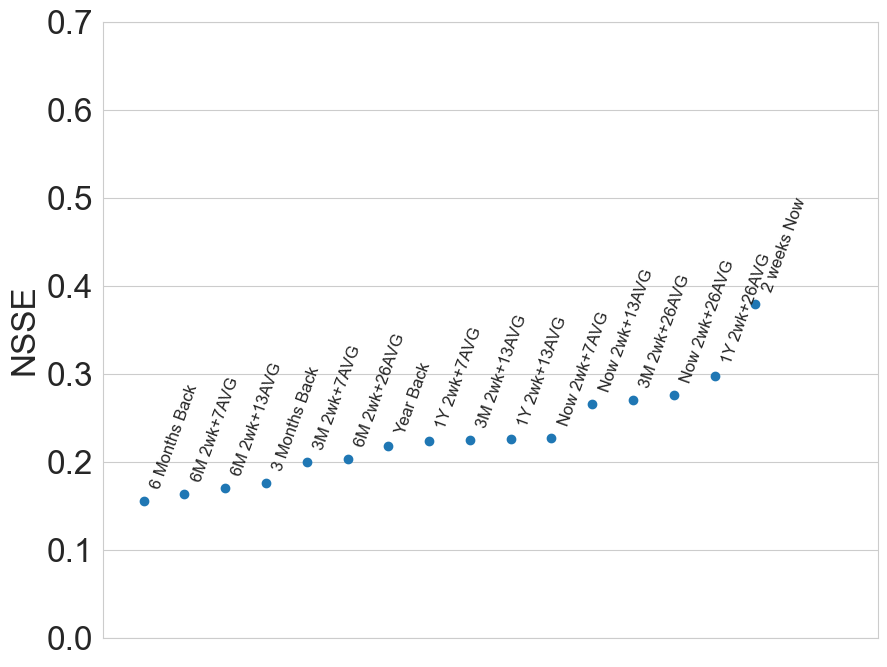

In [11]:
fig, ax = plt.subplots()
df_training['index'] = range(0, len(df_training))
ax.scatter(x=df_training['index'], y=df_training['NNSE'])
# plt.xlabel('index')

# generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
for idx, row in df_training.iterrows():
    ax.annotate('   ' + row['name'], (row['index'], row['NNSE']), rotation=70, fontsize=12, fontfamily="Arial")
plot_figure(fig, ax, title=None, size=[10,8], name="abc", y="NSSE", axis_font=24, y_range=[0,0.7], x_range=[-1,len(df_training) + 2], visible_xaxis=False)

plt.show()

<Figure size 640x480 with 0 Axes>

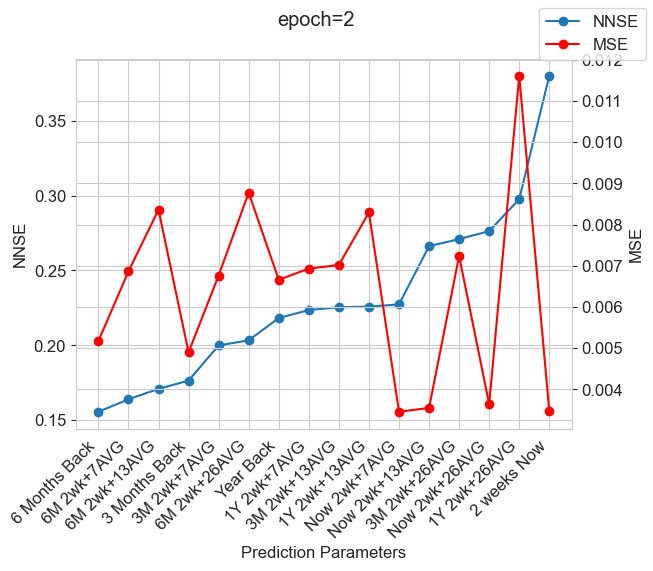

In [12]:
plt.clf()

df_training['MSE'] = df_training['MSE'].astype(float)

# this just creates a new index column
df_training['index'] = range(0, len(df_training))

# fig1, ax = plt.subplots()
# fig1.set_size_inches(20,20)
ax = df_training.plot(x='name', y='NNSE', marker="o", legend=False)
# ax.scatter(x=df_training['2weekIntervals'], y=df_training['NNSE'])
ax1 = ax.twinx()
df_training.plot(x='name', y='MSE', ax=ax1, color='r', marker="o", legend=False)
# ax1.scatter(x=df_training['2weekIntervals'], y=df_training['MSE'], color='r')
# df_training.plot(x="MSE_F", y='index', legend=False, color="r")
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
ax.figure.legend()
plt.suptitle('epoch=2')
plt.xticks(df_training['index'], df_training['name'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Prediction Parameters")
ax.set_ylabel("NNSE")
ax1.set_ylabel("MSE")

plt.show()
# df_training['sortedNNSE'] = df_training.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
# df_training.sort_values(['sortedNNSE', '2weekIntervals'])
# # df_training.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
# plt.plot(df_training['NNSEdecimal'])
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
# plt.show()

In [13]:
result_training = df_training.copy()
result_validation = df_validation.copy()

In [14]:
result_training = result_training[['name', 'NNSE']]
result_training.sort_values('NNSE', inplace=True)
result_training.rename(columns={'name': 'Name'}, inplace=True)
display(result_training)

result_validation = result_validation[['name', 'NNSE']]
result_validation.sort_values('NNSE', inplace=True)
result_validation.rename(columns={'name': 'Name'}, inplace=True)
display(result_validation)

,Name,NNSE
2,6 Months Back,0.1556
6,6M 2wk+7AVG,0.1639
10,6M 2wk+13AVG,0.1709
1,3 Months Back,0.1764
5,3M 2wk+7AVG,0.1999
14,6M 2wk+26AVG,0.2033
3,Year Back,0.2182
7,1Y 2wk+7AVG,0.2235
9,3M 2wk+13AVG,0.2254
11,1Y 2wk+13AVG,0.2258


,Name,NNSE
2,6 Months Back,0.1626
1,3 Months Back,0.1741
10,6M 2wk+13AVG,0.1805
6,6M 2wk+7AVG,0.1816
5,3M 2wk+7AVG,0.1944
14,6M 2wk+26AVG,0.2162
9,3M 2wk+13AVG,0.2195
3,Year Back,0.2208
11,1Y 2wk+13AVG,0.2280
7,1Y 2wk+7AVG,0.2289


In [15]:
content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('./tables/abc.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

In [16]:
content = result_validation[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('./tables/def.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

## MSE Analysis

In [17]:
mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'MSE Full' in line and 'MSE Start' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [18]:
fixed_dicts = []
list_of_dicts_of_values = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    list_of_dicts_of_values.append(working_line['value'])


In [19]:
df_mse = pd.DataFrame(list_of_dicts_of_values)
# display(df_mse)

last = len(df_training.keys()) - 1
DELETE = -1000

for index, what in [(0, 'name'),
                    (DELETE, "line"),
                    (DELETE, "result"),
                    (DELETE, "RunTFTCustomVersion MSE"),
                    (DELETE, "MSE_event_num")]:
    col = df_mse.pop(what)
    if index != DELETE:
        df_mse.insert(index, what, col)
display(df_mse)

,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total
0,Next Magnitude 2 weeks Now,0,83.42,130.25,36.29,0.003468,0.002861,0.004191,35.18%
1,Next Mag 3 Months Back,1,61.57,67.57,17.15,0.004899,0.005172,0.004574,17.41%
2,Next Mag 6 Months Back,2,54.99,58.35,15.47,0.005170,0.005806,0.004412,16.26%
3,Next Mag Year Back,3,53.55,55.24,21.79,0.006657,0.007491,0.005664,22.08%
4,Magnitude 2 weeks Now 2wk+2,4,82.82,129.49,28.67,0.003420,0.002809,0.004148,29.21%
...,...,...,...,...,...,...,...,...,...
99,Mag Year Back 2wk+25,99,70.12,75.05,29.70,0.011475,0.012544,0.010163,30.56%
100,Magnitude 2 weeks Now 2wk+26,100,85.17,124.24,26.72,0.003639,0.002973,0.004458,29.28%
101,Mag 3 Months Back 2wk+26,101,74.73,82.64,26.92,0.007236,0.007400,0.007036,26.96%
102,Mag 6 Months Back 2wk+26,102,71.44,81.13,20.36,0.008773,0.009367,0.008043,21.62%


0        Text(0, 0.003468, 'Next Magnitude 2 weeks Now')
1            Text(1, 0.004899, 'Next Mag 3 Months Back')
2             Text(2, 0.00517, 'Next Mag 6 Months Back')
3                Text(3, 0.006657, 'Next Mag Year Back')
4        Text(4, 0.00342, 'Magnitude 2 weeks Now 2wk+2')
                             ...                        
99            Text(99, 0.011475, 'Mag Year Back 2wk+25')
100    Text(100, 0.003639, 'Magnitude 2 weeks Now 2wk...
101      Text(101, 0.007236, 'Mag 3 Months Back 2wk+26')
102      Text(102, 0.008773, 'Mag 6 Months Back 2wk+26')
103          Text(103, 0.011611, 'Mag Year Back 2wk+26')
Length: 104, dtype: object

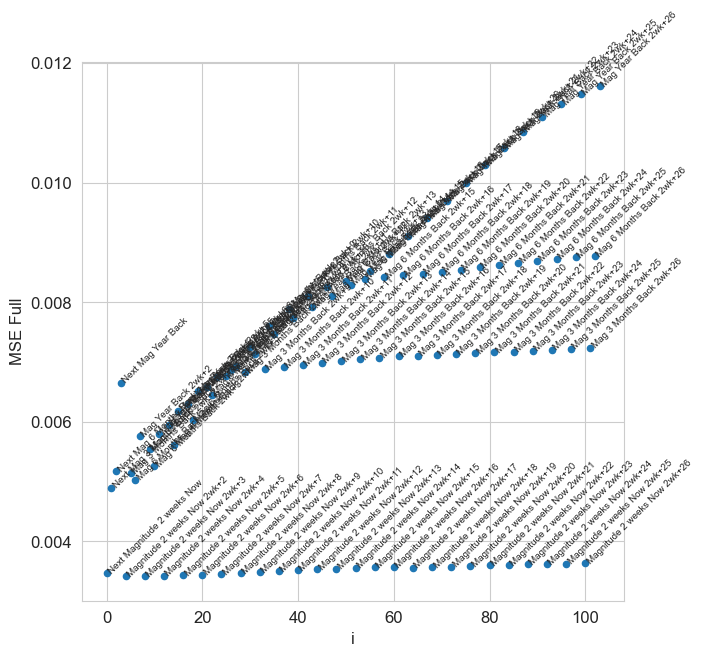

In [20]:
ax = df_mse.plot(x='i', y='MSE Full', kind='scatter', figsize=(7,7))
df_mse[['i', 'MSE Full', 'name']].apply(lambda x: ax.text(*x, rotation=45, fontsize=7),axis=1)
# add a new color for each line
# if '2 weeks now' in name, make it a certain color

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
0,Next Magnitude 2 weeks Now,0,83.42,130.25,36.29,0.003468,0.002861,0.004191,35.18%,0,Now
4,Magnitude 2 weeks Now 2wk+2,4,82.82,129.49,28.67,0.003420,0.002809,0.004148,29.21%,1,2wk+2
8,Magnitude 2 weeks Now 2wk+3,8,82.77,126.89,26.10,0.003419,0.002808,0.004148,27.45%,2,2wk+3
12,Magnitude 2 weeks Now 2wk+4,12,82.85,125.79,24.85,0.003428,0.002821,0.004154,26.6%,3,2wk+4
16,Magnitude 2 weeks Now 2wk+5,16,82.88,123.28,23.25,0.003433,0.002822,0.004165,25.61%,4,2wk+5
20,Magnitude 2 weeks Now 2wk+6,20,82.94,121.48,21.74,0.003440,0.002827,0.004176,24.72%,5,2wk+6
24,Magnitude 2 weeks Now 2wk+7,24,83.09,120.87,21.56,0.003455,0.002840,0.004193,24.77%,6,2wk+7
28,Magnitude 2 weeks Now 2wk+8,28,83.27,120.79,22.34,0.003471,0.002854,0.004213,25.41%,7,2wk+8
32,Magnitude 2 weeks Now 2wk+9,32,83.41,120.61,23.45,0.003485,0.002866,0.004230,25.91%,8,2wk+9
36,Magnitude 2 weeks Now 2wk+10,36,83.60,120.35,24.89,0.003502,0.002880,0.004251,26.9%,9,2wk+10


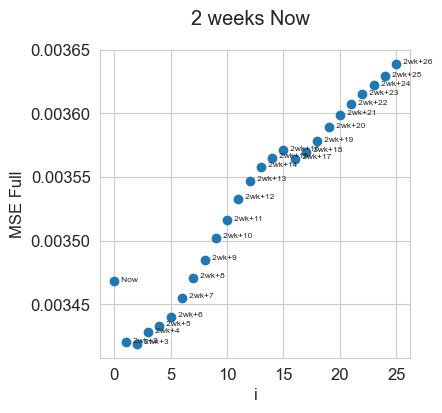

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
1,Next Mag 3 Months Back,1,61.57,67.57,17.15,0.004899,0.005172,0.004574,17.41%,0,Back
5,Mag 3 Months Back 2wk+2,5,63.07,68.59,16.14,0.005145,0.005441,0.004793,16.54%,1,2wk+2
9,Mag 3 Months Back 2wk+3,9,65.41,71.05,16.98,0.005540,0.005848,0.005172,17.29%,2,2wk+3
13,Mag 3 Months Back 2wk+4,13,67.79,73.90,17.74,0.005955,0.006269,0.005578,17.99%,3,2wk+4
17,Mag 3 Months Back 2wk+5,17,69.71,76.15,18.33,0.006303,0.006619,0.005925,18.6%,4,2wk+5
21,Mag 3 Months Back 2wk+6,21,71.17,77.90,18.93,0.006576,0.006893,0.006195,19.09%,5,2wk+6
25,Mag 3 Months Back 2wk+7,25,72.15,79.28,19.37,0.006762,0.007079,0.006382,19.44%,6,2wk+7
29,Mag 3 Months Back 2wk+8,29,72.48,79.73,19.56,0.006827,0.007143,0.006447,19.64%,7,2wk+8
33,Mag 3 Months Back 2wk+9,33,72.72,79.97,19.93,0.006876,0.007191,0.006497,19.97%,8,2wk+9
37,Mag 3 Months Back 2wk+10,37,72.90,80.06,20.59,0.006913,0.007226,0.006536,20.53%,9,2wk+10


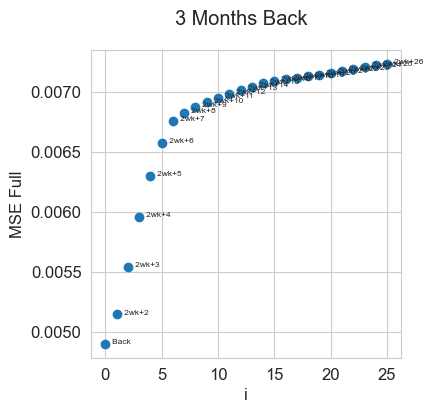

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
2,Next Mag 6 Months Back,2,54.99,58.35,15.47,0.005170,0.005806,0.004412,16.26%,0,Back
6,Mag 6 Months Back 2wk+2,6,54.28,56.03,14.67,0.005036,0.005663,0.004289,15.93%,1,2wk+2
10,Mag 6 Months Back 2wk+3,10,55.49,56.70,16.04,0.005261,0.005857,0.004549,17.51%,2,2wk+3
14,Mag 6 Months Back 2wk+4,14,57.33,58.44,16.44,0.005620,0.006217,0.004905,18.11%,3,2wk+4
18,Mag 6 Months Back 2wk+5,18,59.35,60.88,16.66,0.006031,0.006647,0.005293,18.39%,4,2wk+5
22,Mag 6 Months Back 2wk+6,22,61.34,63.55,16.64,0.006452,0.007101,0.005674,18.4%,5,2wk+6
26,Mag 6 Months Back 2wk+7,26,63.20,66.26,16.38,0.006861,0.007551,0.006033,18.16%,6,2wk+7
30,Mag 6 Months Back 2wk+8,30,64.89,68.87,16.10,0.007244,0.007970,0.006370,17.86%,7,2wk+8
34,Mag 6 Months Back 2wk+9,34,66.41,71.15,16.23,0.007596,0.008346,0.006692,17.88%,8,2wk+9
38,Mag 6 Months Back 2wk+10,38,67.65,73.09,16.54,0.007889,0.008663,0.006958,18.04%,9,2wk+10


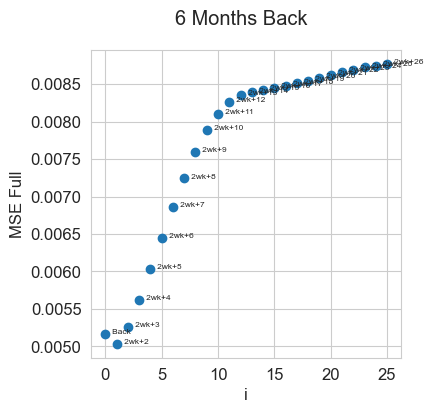

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
3,Next Mag Year Back,3,53.55,55.24,21.79,0.006657,0.007491,0.005664,22.08%,0,Back
7,Mag Year Back 2wk+2,7,49.82,48.30,19.09,0.005755,0.006540,0.004820,19.27%,1,2wk+2
11,Mag Year Back 2wk+3,11,50.14,46.57,20.62,0.005801,0.006425,0.005056,20.67%,2,2wk+3
15,Mag Year Back 2wk+4,15,51.86,47.21,21.88,0.006184,0.006661,0.005612,22.18%,3,2wk+4
19,Mag Year Back 2wk+5,19,53.23,48.47,22.38,0.006511,0.006953,0.005981,22.94%,4,2wk+5
23,Mag Year Back 2wk+6,23,54.14,49.62,22.37,0.006742,0.007225,0.006163,23.06%,5,2wk+6
27,Mag Year Back 2wk+7,27,54.83,50.67,22.20,0.006930,0.007492,0.006255,22.89%,6,2wk+7
31,Mag Year Back 2wk+8,31,55.58,51.74,22.22,0.007136,0.007778,0.006363,22.82%,7,2wk+8
35,Mag Year Back 2wk+9,35,56.83,53.03,22.96,0.007470,0.008139,0.006664,23.38%,8,2wk+9
39,Mag Year Back 2wk+10,39,57.75,54.34,23.25,0.007729,0.008478,0.006828,23.57%,9,2wk+10


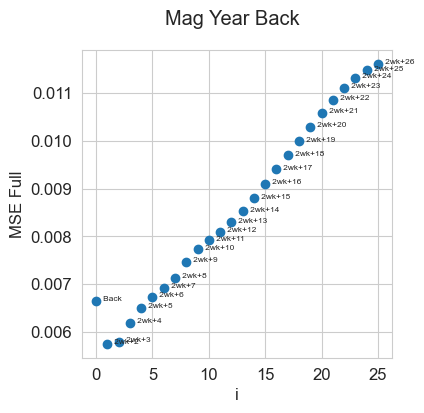

In [21]:
dataframe_dict = {}
mse_list = ['2 weeks Now', '3 Months Back', '6 Months Back', 'Mag Year Back']
for mse in mse_list:
    generated_df = df_mse[df_mse['name'].str.contains(mse)]
    generated_df['index'] = range(0, len(generated_df))
    for index, row in generated_df.iterrows():
        generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]
    display(generated_df)
    dataframe_dict[mse] = generated_df
    fig, ax = plt.subplots()
    ax.scatter(x=generated_df['index'], y=generated_df['MSE Full'])
    fig.set_size_inches(4,4)
    fig.suptitle(mse)
    plt.xlabel('i')
    plt.ylabel('MSE Full')
    # generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
    for idx, row in generated_df.iterrows():
        ax.annotate('   ' + row['2weekIntervals'], (row['index'], row['MSE Full']), rotation=0, fontsize=6)
    plt.show()
    # dataframe_list.append(generated_df)

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3126068574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


2-weeks-now


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3126068574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


3-months-back


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3126068574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


6-months-back


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3126068574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


mag-year-back


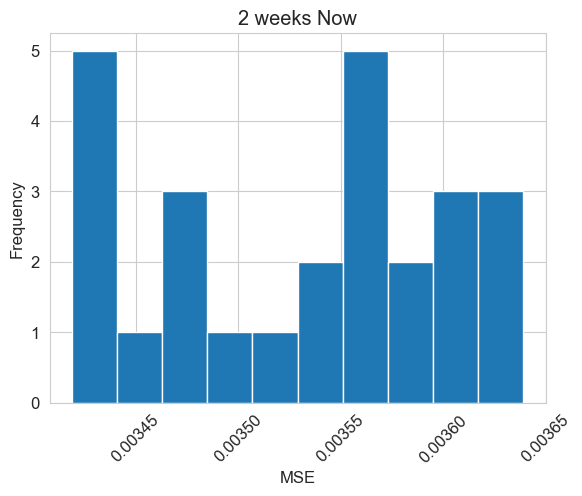

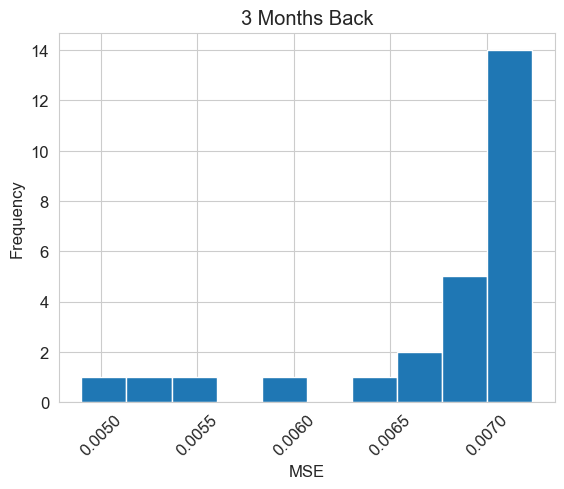

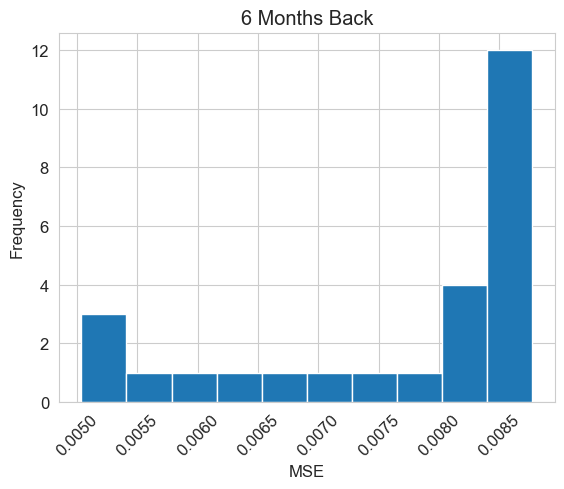

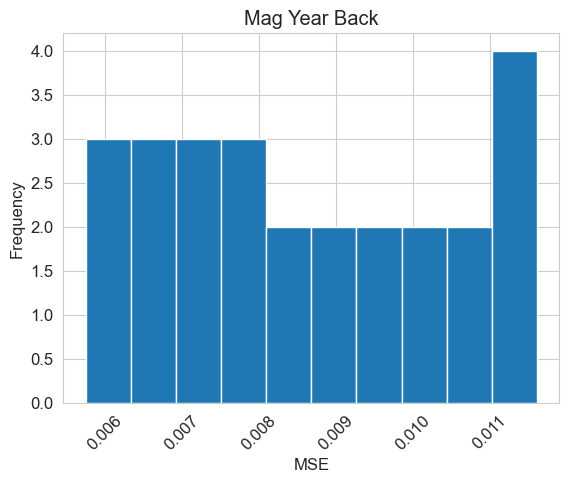

In [22]:


for key, df in dataframe_dict.items():
    df.rename(columns={'MSE Full': 'MSE'}, inplace=True)
    df.hist(column='MSE')
    plt.title(key)
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    temp_key = key.replace(' ', '-').lower()
    print(temp_key)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    plt.tick_params(axis='x', rotation=45)
    image_file = Shell.map_filename(f'./images/{temp_key}-MSE.pdf').path
    #plt.savefig(image_file)
    # SAVEFIG(plt, f'./images/{temp_key}-MSE')
    #plt.show()


In [23]:
# fig, ax = plt.subplots()
# ax.scatter(x=df_mse['i'],y=df_mse['MSE Full'],c='DarkBlue')
# ax.set_xlabel('i')
# ax.set_ylabel('MSE Full')

In [24]:
# df_mse.reset_index().plot.scatter(x='index', y='MSE Full', ax=ax)

In [25]:
# for i, txt in enumerate(df_mse.result):
#     ax.annotate(txt, (df_mse['i'].iat[i], df_mse['MSE Full'].iat[i]))

In [26]:
# plt.show()

In [27]:
verbose = False

dict_of_log = {}

epochs = ["2","30","70"]
repeats = ["1","2","3","4","5"]

for epoch in epochs:
    for repeat in repeats:
        dict_of_log[f'{epoch},{repeat}'] = Shell.map_filename(
            f'../experiments/rivanna/localscratch/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB' \
            f'_repeat_{repeat}_TFTTransformerepochs_{epoch}/cloudmesh_mllog.log').path

mynotebooks = {}

for key, value in dict_of_log.items():
    temp_readfile = readfile(value)
    if verbose:
        print(temp_readfile[:300])
    mynotebooks[key] = temp_readfile

count_lines = 0
dict_of_lines = {}
for epoch in epochs:
    for repeat in repeats:
        dict_of_lines[f'{epoch},{repeat}'] = []

for key, value in list(mynotebooks.items()):
    for line in value.splitlines():
        #line.replace('\\', '')
        if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
            dict_of_lines[key].append(line)

            count_lines += 1
            if verbose:
                print(line)

if verbose:
    print(count_lines)

In [28]:
print(len(dict_of_lines['2,1']))
print(len(dict_of_lines['30,1']))
print(len(dict_of_lines['70,1']))
# print(dict_of_lines['2'])


32
32
32


In [29]:

# pprint(fixed_dicts)
# print(len(dict_of_lines.values()))
dict_of_epochs = {}
for key, value in dict_of_lines.items():
    # print(len(value))
    # print(key)
    for iterated_line in value:
        # print(iterated_line)
        working_line = iterated_line.strip()
        # print(type(working_line))
        # print(working_line)
        working_line = working_line.replace(':::MLLOG ', '')
        # print('a', working_line)
        working_line = working_line[:-3]
        # print('b', working_line)
        working_line = working_line.replace('\\', '')
        # print('c', working_line)
        working_line = working_line.split(', "metadata":', 1)[0]
        working_line += '}'
        working_line = eval(working_line)
        working_line['value'] = eval(working_line['value'])
        # print('d', working_line)
        # print(type(working_line))

        # interpreting scientific values
        parse_line = working_line['value']['extrastring']
        parse_list = parse_line.split()

        # this function returns the value after a specified word
        def looking_for(seeking_value: str):
            found_it = False
            for word in parse_list:
                if found_it:
                    return word
                if word == seeking_value:
                    found_it = True
                    continue

        validation_value = looking_for('Validation')
        if validation_value:
            working_line['value']['validation'] = validation_value
        training_value = looking_for('Training')
        if training_value:
            working_line['value']['training'] = training_value

        list_of_values = []
        working_line['value']['MSE'] = {}
        for word in parse_list:
            if '=' in word and ('F' in word or 'S' in word or 'E' in word):
                temp_word = word.split('=')
                working_line['value']['MSE'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
        working_line['value']['title'] = working_line['key']
        working_line['key'] = 'result'

        program_title = looking_for('UTC')
        working_line['value']['program'] = program_title
        nnse = looking_for('summedErr/SummedObs')
        working_line['value']['NNSE'] = nnse
        comment = looking_for('TOTAL')
        working_line['value']['comment'] = comment

        future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
        try:
            working_line['value']['future'] = future.group(1)
        except AttributeError:
            pass

        loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
        working_line['value']['location_summed_results'] = loc_sum.group(1)
        del working_line['value']['extrastring']
        # pprint(working_line)

        try:
            if not dict_of_epochs[key]:
                dict_of_epochs[key] = []
        except KeyError:
            dict_of_epochs[key] = []

        dict_of_epochs[key].append(working_line)
        # fixed_dicts[key].append(working_line)


In [30]:
if verbose:

    pprint(dict_of_epochs)
        # print(working_line)
print(dict_of_epochs.keys())

print(type(dict_of_epochs['2,1']))
print(type(dict_of_epochs['2,1'][0]))
print(len(dict_of_epochs['2,1']))
print(len(dict_of_epochs['30,1']))
print(len(dict_of_epochs['70,1']))

dict_keys(['2,1', '2,2', '2,3', '2,4', '2,5', '30,1', '30,2', '30,3', '30,4', '30,5', '70,1', '70,2', '70,3', '70,4', '70,5'])
<class 'list'>
<class 'dict'>
32
32
32


In [31]:
# dict_of_dataframes = dict.fromkeys(dict_of_lines.keys(), [])
dict_of_dataframes = {}
# for epoch in epochs:
#     try:
#         if not dict_of_dataframes[f'{epoch}_training']:
#             dict_of_dataframes[f'{epoch}_training'] = None
#     except KeyError:
#         dict_of_dataframes[f'{epoch}_training'] = None
#         # dict_of_epochs[key].append(working_line)
#     try:
#         if not dict_of_dataframes[f'{epoch}_validation']:
#             dict_of_dataframes[f'{epoch}_validation'] = None
#     except KeyError:
#         dict_of_dataframes[f'{epoch}_validation'] = None
#         # dict_of_epochs[key].append(working_line)

for key, value in dict_of_epochs.items():
    repeat_value = key.split(',')[1]
    list_of_value_dicts_training = []
    list_of_value_dicts_validation = []
    fails = 0
    for dictionary in value:
        # try:
        #     if dictionary['value']['training']:
        #         list_of_value_dicts_training.append(dictionary['value'])
        # except KeyError:
        #     list_of_value_dicts_validation.append(dictionary['value'])
        if dictionary.get('value', None).get('training', None):
            list_of_value_dicts_training.append(dictionary['value'])
        elif dictionary.get('value', None).get('validation', None):
            list_of_value_dicts_validation.append(dictionary['value'])
        else:
            fails += 1
    print('fails:', fails)
        #list_of_value_dicts.append(dictionary['value'])

    for iterated_dictionary in list_of_value_dicts_training:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    for iterated_dictionary in list_of_value_dicts_validation:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    df_training = pd.DataFrame(list_of_value_dicts_training)
    df_validation = pd.DataFrame(list_of_value_dicts_validation)

    df_training.drop('MSE', axis=1, inplace=True)
    df_validation.drop('MSE', axis=1, inplace=True)

    df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
    df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

    dataframes = [df_training, df_validation]

    for dataframe in dataframes:
        for index, row in dataframe.iterrows():
            dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

            if dataframe.loc[index, 'future'] is np.nan:
                temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
                remove_words = ['Magnitude', 'Mag']
                for word in remove_words:
                    if word in temp_string_list:
                        temp_string_list.remove(word)
                new_string = " ".join(temp_string_list)
                dataframe.loc[index, 'name'] = new_string

            else:
                added_string = ''
                temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
                if 'Months' in temp_string_list:
                    if '6' in temp_string_list:
                        added_string = '6M '
                    elif '3' in temp_string_list:
                        added_string = '3M '
                elif 'Year' in temp_string_list:
                    added_string = '1Y '
                elif '2' in temp_string_list and 'weeks' in temp_string_list and 'Now' in temp_string_list:
                    added_string = 'Now '
                dataframe.loc[index, 'name'] = added_string + dataframe.loc[index, 'future'].split()[-1]
        dataframe.sort_values('NNSE', inplace=True)

        dataframe.pop("NNSEpercent")
        last = len(df_training.keys()) -1
        DELETE = -1000

        for index, what in [(0, 'name'),
                            (1,"NNSE"),
                            (DELETE, "location_summed_results"),
                            (DELETE, "comment"),
                            (DELETE, "title"),
                            (DELETE, "program")]:
            col = dataframe.pop(what)
            if index != DELETE:
                dataframe.insert(index, what, col)
    df_training['repeat'] = repeat_value
    df_validation['repeat'] = repeat_value
    # display(df_training)
    dict_of_dataframes[f'{key}_training'] = df_training
    # display(df_validation)
    dict_of_dataframes[f'{key}_validation'] = df_validation

fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0
fails: 0


In [32]:
print(dict_of_dataframes.keys())

dict_keys(['2,1_training', '2,1_validation', '2,2_training', '2,2_validation', '2,3_training', '2,3_validation', '2,4_training', '2,4_validation', '2,5_training', '2,5_validation', '30,1_training', '30,1_validation', '30,2_training', '30,2_validation', '30,3_training', '30,3_validation', '30,4_training', '30,4_validation', '30,5_training', '30,5_validation', '70,1_training', '70,1_validation', '70,2_training', '70,2_validation', '70,3_training', '70,3_validation', '70,4_training', '70,4_validation', '70,5_training', '70,5_validation'])


In [33]:
pprint(dict_of_dataframes)

for key, value in dict_of_dataframes.items():
    print(len(value))
    print(key)
    epoch = key.split(',')[0]
    training_or_validation = key.split('_')[1]
    value['epoch'] = epoch
    value['epoch'] = value['epoch'].astype(float)
    print('epoch:', epoch)

    value['type of run'] = training_or_validation
    print('type of run:', training_or_validation)

{'2,1_training':              name    NNSE training      A     AT      S     ST       MSE  \
2   6 Months Back  0.1556  0.68565  0.608  0.607  0.777  0.772   0.00517   
6     6M 2wk+7AVG  0.1639  0.68565  0.608  0.607  0.777  0.772  0.006861   
10   6M 2wk+13AVG  0.1709  0.68565  0.608  0.607  0.777  0.772   0.00836   
1   3 Months Back  0.1764  0.68565  0.499    NaN  0.588    NaN  0.004899   
5     3M 2wk+7AVG  0.1999  0.68565  0.499    NaN  0.588    NaN  0.006762   
14   6M 2wk+26AVG  0.2033  0.68565  0.608  0.607  0.777  0.772  0.008773   
3       Year Back  0.2182  0.68565  0.608    NaN  0.777    NaN  0.006657   
7     1Y 2wk+7AVG  0.2235  0.68565  0.608    NaN  0.777    NaN   0.00693   
9    3M 2wk+13AVG  0.2254  0.68565  0.499    NaN  0.588    NaN  0.007017   
11   1Y 2wk+13AVG  0.2258  0.68565  0.608    NaN  0.777    NaN  0.008292   
4    Now 2wk+7AVG  0.2273  0.68565  0.499  0.498  0.588  0.568  0.003455   
8   Now 2wk+13AVG  0.2662  0.68565  0.499  0.498  0.588  0.568  0.00354

dict_keys(['2,1_training', '2,1_validation', '2,2_training', '2,2_validation', '2,3_training', '2,3_validation', '2,4_training', '2,4_validation', '2,5_training', '2,5_validation', '30,1_training', '30,1_validation', '30,2_training', '30,2_validation', '30,3_training', '30,3_validation', '30,4_training', '30,4_validation', '30,5_training', '30,5_validation', '70,1_training', '70,1_validation', '70,2_training', '70,2_validation', '70,3_training', '70,3_validation', '70,4_training', '70,4_validation', '70,5_training', '70,5_validation'])


C:\Users\stapm\ENV3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

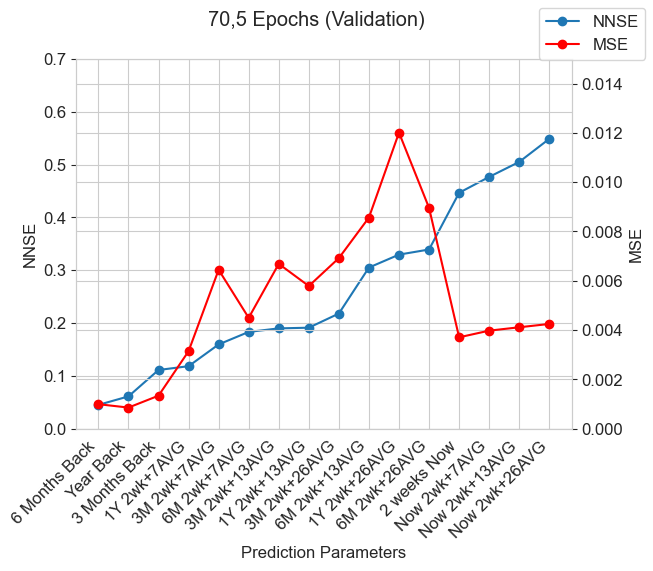

In [34]:
print(dict_of_dataframes.keys())
for key, value in dict_of_dataframes.items():
    plt.clf()
    value['MSE'] = value['MSE'].astype(float)
    value['index'] = range(0, len(value))
    ax = value.plot(x='name', y='NNSE', marker="o", legend=False, ylim=[0, 0.7])
    ax1 = ax.twinx()
    value.plot(x='name', y='MSE', ax=ax1, color='r', marker="o", legend=False, ylim=[0, 0.015])
    # value.plot(x="MSE_F", y='index', legend=False, color="r")
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    ax.figure.legend()
    num_epochs = key.split('_')[0]
    type_of_graph = key.split('_')[1].capitalize()
    plt.suptitle(f'{num_epochs} Epochs ({type_of_graph})')
    plt.xticks(value['index'], value['name'])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Prediction Parameters")
    ax.set_ylabel("NNSE")
    ax1.set_ylabel("MSE")

    temp_key = key.replace(' ', '-').lower()
    # image_file = Shell.map_filename(f'./images/{temp_key}-MSE-and-NNSE.png').path
    # image_file = Shell.map_filename(f'./images/{temp_key}-MSE-and-NNSE.pdf').path
    #plt.savefig(image_file, bbox_inches='tight')
    SAVEFIG(plt, f'./images/{temp_key}-MSE-and-NNSE')
    #plt.show()
    # value['sortedNNSE'] = value.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
    # value.sort_values(['sortedNNSE', '2weekIntervals'])
    # # value.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
    # plt.plot(value['NNSEdecimal'])
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    # plt.show()

dict_keys(['2,1_training', '2,1_validation', '2,2_training', '2,2_validation', '2,3_training', '2,3_validation', '2,4_training', '2,4_validation', '2,5_training', '2,5_validation', '30,1_training', '30,1_validation', '30,2_training', '30,2_validation', '30,3_training', '30,3_validation', '30,4_training', '30,4_validation', '30,5_training', '30,5_validation', '70,1_training', '70,1_validation', '70,2_training', '70,2_validation', '70,3_training', '70,3_validation', '70,4_training', '70,4_validation', '70,5_training', '70,5_validation'])
2,1_training
2,1_validation
2,2_training
2,2_validation
2,3_training
2,3_validation
2,4_training
2,4_validation
2,5_training
2,5_validation
30,1_training
30,1_validation
30,2_training
30,2_validation
30,3_training
30,3_validation
30,4_training
30,4_validation
30,5_training
30,5_validation
70,1_training
70,1_validation
70,2_training
70,2_validation
70,3_training
70,3_validation
70,4_training
70,4_validation
70,5_training
70,5_validation
2,1_training
2,1_v

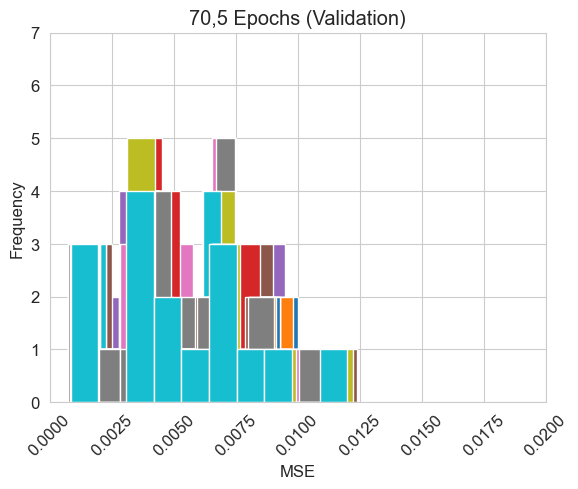

In [35]:
types_of_graphs = ['NNSE', 'MSE']
print(dict_of_dataframes.keys())
for graph in types_of_graphs:
    for key, df in dict_of_dataframes.items():
        # df.rename(columns={'MSE Full': 'MSE'}, inplace=True)
        x_lim = None
        if graph == 'NNSE':
            x_lim = [0.0, 0.6]
        else:
            x_lim = [0.0, 0.02]
        ax_list = df[graph].plot.hist(ylim=[0,7], xlim=x_lim)
        # ax_list.set_xlim(x_lim)
        # ax_list.set_ylim([0,7])
        num_epochs = key.split('_')[0]
        type_of_graph = key.split('_')[1].capitalize()
        plt.title(f'{num_epochs} Epochs ({type_of_graph})')
        plt.xlabel(graph)
        plt.ylabel('Frequency')
        temp_key = key.replace(' ', '-').lower()
        print(temp_key)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        plt.tick_params(axis='x', rotation=45)
        image_file = Shell.map_filename(f'./images/{temp_key}-{graph}.pdf').path
        #plt.savefig(image_file)
        SAVEFIG(plt, f'./images/{temp_key}-{graph}')
        #plt.show()

In [36]:
mega_training_dataframe = pd.DataFrame()
mega_validation_dataframe = pd.DataFrame()

training_dfs = []
validation_dfs = []
for key, value in dict_of_dataframes.items():
    if 'training' in key:
        training_dfs.append(value)
    elif 'validation' in key:
        validation_dfs.append(value)
    else:
        print('fail')

mega_training_dataframe = pd.concat(training_dfs)
mega_validation_dataframe = pd.concat(validation_dfs)

In [37]:
t_sorted_by_nnse = mega_training_dataframe.sort_values('NNSE', ascending=False)

repeat_column = t_sorted_by_nnse.pop("repeat")
t_sorted_by_nnse.insert(0, "repeat", repeat_column)
epoch_column = t_sorted_by_nnse.pop("epoch")
t_sorted_by_nnse.insert(0, "epoch", epoch_column)
display(t_sorted_by_nnse[0:10])

,epoch,repeat,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,type of run,index
12,70.0,4,Now 2wk+26AVG,0.6930,0.58372,0.52,0.518,0.469,0.443,0.004041,0.003241,0.005025,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
12,70.0,5,Now 2wk+26AVG,0.6681,0.59391,0.518,0.516,0.455,0.429,0.004055,0.003262,0.005029,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
8,70.0,4,Now 2wk+13AVG,0.6549,0.58372,0.52,0.518,0.469,0.443,0.003879,0.003144,0.004766,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,training,14
12,30.0,5,Now 2wk+26AVG,0.6419,0.59835,0.52,0.518,0.473,0.444,0.004068,0.003253,0.00507,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
12,30.0,1,Now 2wk+26AVG,0.6371,0.60193,0.513,0.512,0.437,0.409,0.004036,0.00324,0.005015,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
8,70.0,5,Now 2wk+13AVG,0.6295,0.59391,0.518,0.516,0.455,0.429,0.003899,0.003169,0.004781,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,training,14
4,70.0,4,Now 2wk+7AVG,0.6274,0.58372,0.52,0.518,0.469,0.443,0.003726,0.003048,0.004541,NaN,NaN,Magnitude 2 weeks Now 2wk+7AVG,training,13
12,30.0,2,Now 2wk+26AVG,0.6178,0.6249,0.509,0.507,0.399,0.376,0.004054,0.003247,0.005045,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
12,30.0,4,Now 2wk+26AVG,0.6101,0.58718,0.512,0.511,0.413,0.386,0.004122,0.003287,0.005147,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,training,15
8,30.0,1,Now 2wk+13AVG,0.6063,0.60193,0.513,0.512,0.437,0.409,0.003888,0.003146,0.004785,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,training,14


In [38]:
v_sorted_by_nnse = mega_validation_dataframe.sort_values('NNSE', ascending=False)

repeat_column = v_sorted_by_nnse.pop("repeat")
v_sorted_by_nnse.insert(0, "repeat", repeat_column)
epoch_column = v_sorted_by_nnse.pop("epoch")
v_sorted_by_nnse.insert(0, "epoch", epoch_column)
display(v_sorted_by_nnse[0:10])

,epoch,repeat,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,type of run,index
12,70.0,4,Now 2wk+26AVG,0.5582,0.57948,0.52,0.518,0.469,0.443,0.004235,0.003575,0.005047,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
12,70.0,5,Now 2wk+26AVG,0.5487,0.58954,0.518,0.516,0.455,0.429,0.004245,0.003592,0.005048,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
0,2.0,5,2 weeks Now,0.5377,0.69926,0.474,0.474,0.321,0.309,0.004238,0.003454,0.005172,NaN,NaN,NaN,validation,15
12,2.0,3,Now 2wk+26AVG,0.5292,0.73973,0.489,0.488,0.361,0.347,0.004357,0.003543,0.005359,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
12,30.0,5,Now 2wk+26AVG,0.5246,0.59282,0.52,0.518,0.473,0.444,0.004245,0.003556,0.005092,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
8,70.0,4,Now 2wk+13AVG,0.5156,0.57948,0.52,0.518,0.469,0.443,0.004092,0.003513,0.004793,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,validation,14
12,30.0,1,Now 2wk+26AVG,0.5150,0.59839,0.513,0.512,0.437,0.409,0.004219,0.003547,0.005046,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
12,30.0,2,Now 2wk+26AVG,0.5133,0.62035,0.509,0.507,0.399,0.376,0.004253,0.003566,0.005099,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15
8,70.0,5,Now 2wk+13AVG,0.5050,0.58954,0.518,0.516,0.455,0.429,0.004110,0.003531,0.00481,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,validation,14
12,30.0,4,Now 2wk+26AVG,0.5034,0.58336,0.512,0.511,0.413,0.386,0.004310,0.003594,0.00519,NaN,NaN,Magnitude 2 weeks Now 2wk+26AVG,validation,15


In [39]:
# training dataframe first

t_epoch_70 = mega_training_dataframe.loc[mega_training_dataframe['epoch'] == 70.0]
t_repeat_4_epoch_70 = t_epoch_70.loc[t_epoch_70['repeat'] == '4']

t_list_of_names = t_sorted_by_nnse['name'].tolist()
display(t_repeat_4_epoch_70)
print(t_list_of_names)

,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,epoch,type of run,index
3,Year Back,0.0259,0.58372,0.844,NaN,0.977,NaN,0.000741,0.00091,0.00054,0.847,0.969,NaN,4,70.0,training,0
2,6 Months Back,0.0371,0.58372,0.844,0.843,0.977,0.976,0.000936,0.001034,0.00082,NaN,NaN,NaN,4,70.0,training,1
1,3 Months Back,0.0502,0.58372,0.52,NaN,0.469,NaN,0.001346,0.001458,0.001213,0.526,0.563,NaN,4,70.0,training,2
7,1Y 2wk+7AVG,0.0997,0.58372,0.844,NaN,0.977,NaN,0.002828,0.003309,0.00225,0.847,0.969,Mag Year Back 2wk+7AVG,4,70.0,training,3
11,1Y 2wk+13AVG,0.1933,0.58372,0.844,NaN,0.977,NaN,0.005319,0.006203,0.004251,0.847,0.969,Mag Year Back 2wk+13AVG,4,70.0,training,4
6,6M 2wk+7AVG,0.2025,0.58372,0.844,0.843,0.977,0.976,0.004589,0.005142,0.003925,NaN,NaN,Mag 6 Months Back 2wk+7AVG,4,70.0,training,5
5,3M 2wk+7AVG,0.2685,0.58372,0.52,NaN,0.469,NaN,0.006703,0.0071,0.006227,0.526,0.563,Mag 3 Months Back 2wk+7AVG,4,70.0,training,6
9,3M 2wk+13AVG,0.3238,0.58372,0.52,NaN,0.469,NaN,0.007015,0.007334,0.006629,0.526,0.563,Mag 3 Months Back 2wk+13AVG,4,70.0,training,7
15,1Y 2wk+26AVG,0.3339,0.58372,0.844,NaN,0.977,NaN,0.011299,0.013283,0.00886,0.847,0.969,Mag Year Back 2wk+26AVG,4,70.0,training,8
10,6M 2wk+13AVG,0.3475,0.58372,0.844,0.843,0.977,0.976,0.008791,0.00985,0.007509,NaN,NaN,Mag 6 Months Back 2wk+13AVG,4,70.0,training,9


['Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', 'Now 2wk+7AVG', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+7AVG', '2 weeks Now', '2 weeks Now', 'Now 2wk+13AVG', 'Now 2wk+26AVG', '2 weeks Now', 'Now 2wk+7AVG', 'Now 2wk+13AVG', 'Now 2wk+13AVG', 'Now 2wk+7AVG', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+7AVG', 'Now 2wk+26AVG', '2 weeks Now', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', '2 weeks Now', '3M 2wk+26AVG', '2 weeks Now', '3M 2wk+26AVG', '2 weeks Now', '3M 2wk+26AVG', 'Now 2wk+13AVG', '2 weeks Now', '3M 2wk+26AVG', 'Now 2wk+7AVG', '6M 2wk+26AVG', 'Now 2wk+7AVG', '3M 2wk+13AVG', 'Now 2wk+13AVG', '3M 2wk+13AVG', '3M 2wk+26AVG', '2 weeks Now', '6M 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+7AVG', '6M 2wk+26AVG', '3M 2wk+13AVG', '6M 2wk+2

In [40]:
# now the validation dataframe

v_epoch_70 = mega_validation_dataframe.loc[mega_validation_dataframe['epoch'] == 70.0]
v_repeat_4_epoch_70 = v_epoch_70.loc[v_epoch_70['repeat'] == '4']

v_list_of_names = v_sorted_by_nnse['name'].tolist()
display(v_repeat_4_epoch_70)
print(v_list_of_names)

,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,epoch,type of run,index
3,Year Back,0.0290,0.57948,0.844,NaN,0.977,NaN,0.000760,0.000929,0.000559,0.847,0.969,NaN,4,70.0,validation,0
2,6 Months Back,0.0417,0.57948,0.844,0.843,0.977,0.976,0.000935,0.001059,0.000787,NaN,NaN,NaN,4,70.0,validation,1
1,3 Months Back,0.0588,0.57948,0.52,NaN,0.469,NaN,0.001337,0.001504,0.001138,0.526,0.563,NaN,4,70.0,validation,2
7,1Y 2wk+7AVG,0.0901,0.57948,0.844,NaN,0.977,NaN,0.002805,0.003305,0.002205,0.847,0.969,Mag Year Back 2wk+7AVG,4,70.0,validation,3
11,1Y 2wk+13AVG,0.1719,0.57948,0.844,NaN,0.977,NaN,0.005237,0.00618,0.004097,0.847,0.969,Mag Year Back 2wk+13AVG,4,70.0,validation,4
6,6M 2wk+7AVG,0.1796,0.57948,0.844,0.843,0.977,0.976,0.004510,0.005214,0.003666,NaN,NaN,Mag 6 Months Back 2wk+7AVG,4,70.0,validation,5
5,3M 2wk+7AVG,0.2358,0.57948,0.52,NaN,0.469,NaN,0.006581,0.007283,0.005738,0.526,0.563,Mag 3 Months Back 2wk+7AVG,4,70.0,validation,6
9,3M 2wk+13AVG,0.2801,0.57948,0.52,NaN,0.469,NaN,0.006854,0.007477,0.006101,0.526,0.563,Mag 3 Months Back 2wk+13AVG,4,70.0,validation,7
15,1Y 2wk+26AVG,0.3030,0.57948,0.844,NaN,0.977,NaN,0.011104,0.013156,0.008581,0.847,0.969,Mag Year Back 2wk+26AVG,4,70.0,validation,8
10,6M 2wk+13AVG,0.3092,0.57948,0.844,0.843,0.977,0.976,0.008618,0.009971,0.00698,NaN,NaN,Mag 6 Months Back 2wk+13AVG,4,70.0,validation,9


['Now 2wk+26AVG', 'Now 2wk+26AVG', '2 weeks Now', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', 'Now 2wk+13AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+7AVG', '2 weeks Now', 'Now 2wk+26AVG', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+13AVG', 'Now 2wk+7AVG', '2 weeks Now', 'Now 2wk+13AVG', 'Now 2wk+13AVG', 'Now 2wk+26AVG', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+7AVG', 'Now 2wk+7AVG', '2 weeks Now', 'Now 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', 'Now 2wk+7AVG', '3M 2wk+26AVG', 'Now 2wk+26AVG', '3M 2wk+26AVG', 'Now 2wk+7AVG', '3M 2wk+26AVG', '2 weeks Now', 'Now 2wk+7AVG', '6M 2wk+26AVG', '6M 2wk+26AVG', '3M 2wk+26AVG', '6M 2wk+26AVG', 'Now 2wk+7AVG', '2 weeks Now', 'Now 2wk+7AVG', 'Now 2wk+13AVG', '3M 2wk+26AVG', '6M 2wk+26AVG', '2 weeks Now', '3M 2wk+13AVG', 'Now 2wk+13AVG', '3M 2wk+13AVG', '2 weeks Now', '6M 2wk+26AVG', '2 weeks Now', '3M 2wk+

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2434535310.py:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df,
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2434535310.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2434535310.py:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df,
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2434535310.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


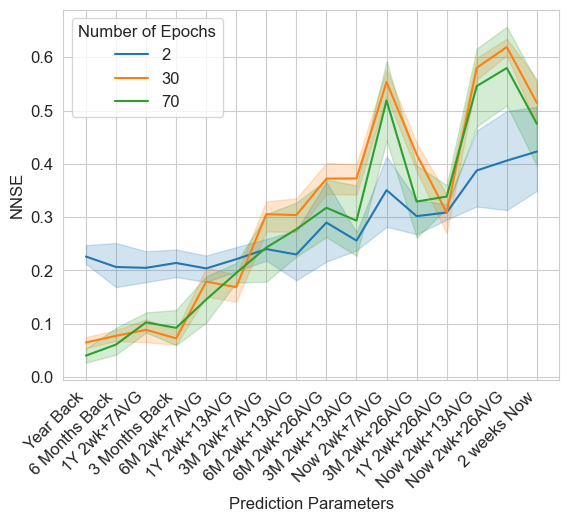

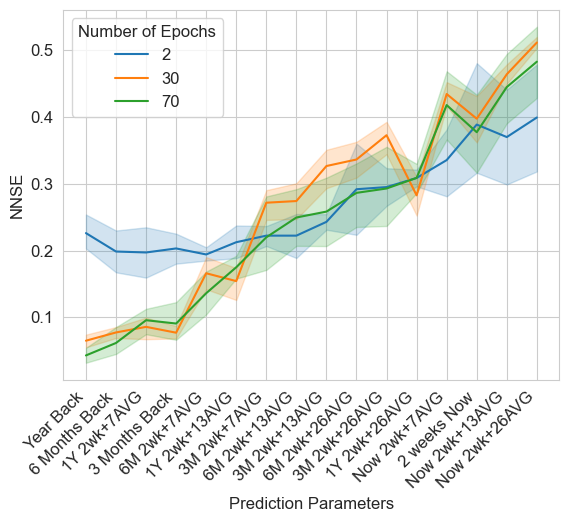

In [41]:
fancy_dict = {'training': mega_training_dataframe,
              'validation': mega_validation_dataframe}

for type_of_df, df in fancy_dict.items():
    # df = mega_training_dataframe.pivot(index='name', columns='epoch', values='NNSE')
# df.plot(figsize=(5,3))

    fig, ax = plt.subplots()

    df = df.sort_values('NNSE')
    palette = sns.color_palette("tab10", 6)
    sns.lineplot(data=df,
                 x="name",
                 y="NNSE",
                 hue='epoch',
                 palette=palette)
    # for labels, dfi in mega_training_dataframe.groupby('epoch'):
    #     dfi.plot(ax = ax, x = 'name', y = 'NNSE', label = labels)

    ax.legend(title='Number of Epochs')
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label[:-2] for label in labels]

    plt.legend(handles, new_labels, title='Number of Epochs')
    # plt.xticks(mega_training_dataframe['index'], mega_training_dataframe['name'])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
             weight='light')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Prediction Parameters")
    ax.set_ylabel("NNSE")
    image_file = Shell.map_filename(f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}.pdf').path
    # plt.savefig(image_file, bbox_inches='tight')
    SAVEFIG(plt, f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}')
    fig.show()


training


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


2.0


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


30.0


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


70.0
validation


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


2.0


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


30.0


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3115241462.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


70.0


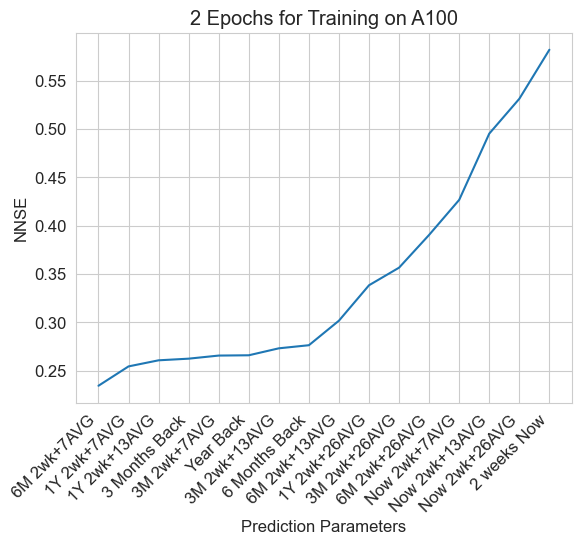

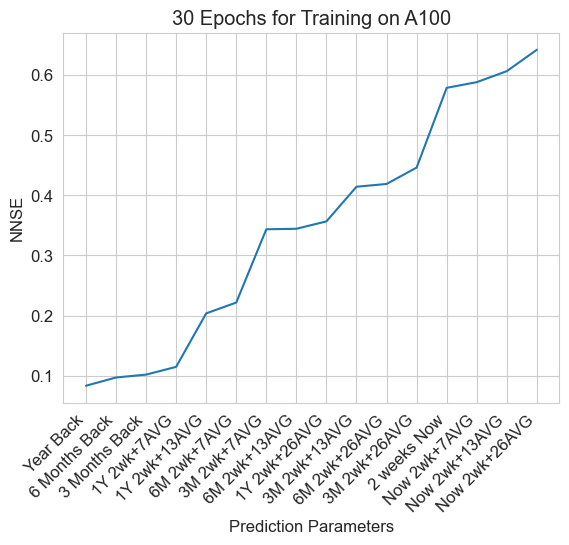

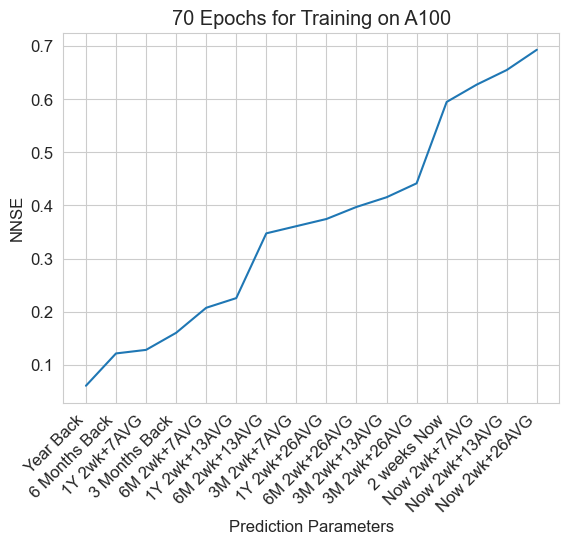

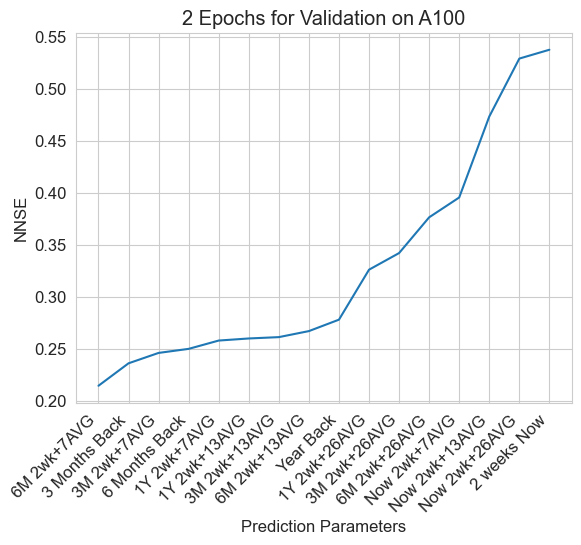

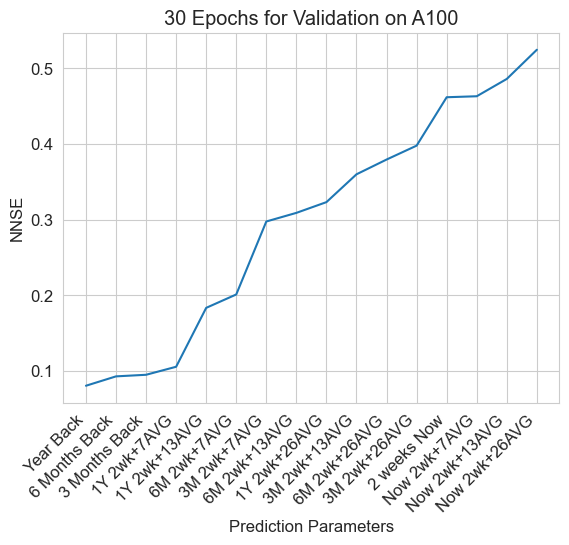

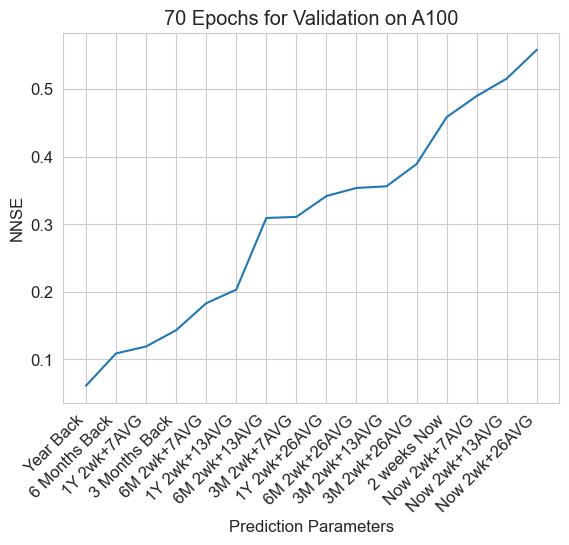

In [42]:
# find best nnse value for each parameter
fancy_dict = {'training': mega_training_dataframe,
              'validation': mega_validation_dataframe}

dict_of_parameter_orders = {}

for type_of_df, df in fancy_dict.items():
    print(type_of_df)
    # repositioning epoch column for readability
    column_to_move = df.pop("epoch")
    df.insert(0, "epoch", column_to_move)

    # display(df.head(20))
    for epoch_value in df.epoch.unique():
        fig, ax = plt.subplots()
        mini_df = df.loc[df.epoch == epoch_value]
        df_final = mini_df.sort_values('NNSE').drop_duplicates('name', keep='last').sort_index()
        # display(df_final)

        df_final = df_final.sort_values('NNSE')
        sns.lineplot(data=df_final,
                     x="name",
                     y="NNSE")

        # plt.xticks(mega_training_dataframe['index'], mega_training_dataframe['name'])
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
                 weight='light')
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel("Prediction Parameters")
        ax.set_ylabel("NNSE")
        plt.title(f'{int(epoch_value)} Epochs for {type_of_df.capitalize()} on {name_of_gpu}')
        # image_file = Shell.map_filename(f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}.pdf').path
        # plt.savefig(image_file, bbox_inches='tight')
        SAVEFIG(plt, f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}')
        fig.show()
        #fig.clear()
        print(epoch_value)
        # create a dict of hyperparameter in order of rising NNSE
        dict_of_parameter_orders[f'{int(epoch_value)}_{type_of_df}'] = df_final['name'].tolist()
    #fig.clf()

In [43]:
pprint(dict_of_parameter_orders)

{'2_training': ['6M 2wk+7AVG',
                '1Y 2wk+7AVG',
                '1Y 2wk+13AVG',
                '3 Months Back',
                '3M 2wk+7AVG',
                'Year Back',
                '3M 2wk+13AVG',
                '6 Months Back',
                '6M 2wk+13AVG',
                '1Y 2wk+26AVG',
                '3M 2wk+26AVG',
                '6M 2wk+26AVG',
                'Now 2wk+7AVG',
                'Now 2wk+13AVG',
                'Now 2wk+26AVG',
                '2 weeks Now'],
 '2_validation': ['6M 2wk+7AVG',
                  '3 Months Back',
                  '3M 2wk+7AVG',
                  '6 Months Back',
                  '1Y 2wk+7AVG',
                  '1Y 2wk+13AVG',
                  '3M 2wk+13AVG',
                  '6M 2wk+13AVG',
                  'Year Back',
                  '1Y 2wk+26AVG',
                  '3M 2wk+26AVG',
                  '6M 2wk+26AVG',
                  'Now 2wk+7AVG',
                  'Now 2wk+13AVG',
                 

In [44]:
ascending_NNSEs = {}

for type_of_df, df in fancy_dict.items():
    df_final = df.sort_values('NNSE').drop_duplicates('name', keep='last').sort_index()
    df_final = df_final.sort_values('NNSE', ascending=True)
    ascending_NNSEs[type_of_df] = df_final['name'].tolist()
    #print(type_of_df)
    display(df_final)
pprint(ascending_NNSEs)

,epoch,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,type of run,index
6,2.0,6M 2wk+7AVG,0.2344,0.68156,0.592,0.591,0.63,0.622,0.006918,0.007673,0.006012,NaN,NaN,Mag 6 Months Back 2wk+7AVG,4,training,3
7,2.0,1Y 2wk+7AVG,0.2544,0.71645,0.594,NaN,0.683,NaN,0.007677,0.008097,0.007172,0.598,0.687,Mag Year Back 2wk+7AVG,3,training,4
11,2.0,1Y 2wk+13AVG,0.2607,0.71645,0.594,NaN,0.683,NaN,0.008792,0.009664,0.007737,0.598,0.687,Mag Year Back 2wk+13AVG,3,training,5
1,2.0,3 Months Back,0.2624,0.68156,0.506,NaN,0.511,NaN,0.005229,0.005415,0.005008,0.511,0.583,NaN,4,training,5
3,2.0,Year Back,0.2659,0.71645,0.594,NaN,0.683,NaN,0.008409,0.009003,0.007702,0.598,0.687,NaN,3,training,7
2,2.0,6 Months Back,0.2763,0.68156,0.592,0.591,0.63,0.622,0.005143,0.005405,0.00483,NaN,NaN,NaN,4,training,7
10,70.0,6M 2wk+13AVG,0.3475,0.58372,0.844,0.843,0.977,0.976,0.008791,0.00985,0.007509,NaN,NaN,Mag 6 Months Back 2wk+13AVG,4,training,9
5,70.0,3M 2wk+7AVG,0.3610,0.59776,0.492,NaN,0.295,NaN,0.006880,0.007258,0.006426,0.499,0.39,Mag 3 Months Back 2wk+7AVG,2,training,8
15,70.0,1Y 2wk+26AVG,0.3745,0.59776,0.847,NaN,0.957,NaN,0.011918,0.01398,0.009384,0.851,0.952,Mag Year Back 2wk+26AVG,2,training,9
9,70.0,3M 2wk+13AVG,0.4154,0.59776,0.492,NaN,0.295,NaN,0.007261,0.007563,0.006895,0.499,0.39,Mag 3 Months Back 2wk+13AVG,2,training,10


,epoch,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,type of run,index
6,2.0,6M 2wk+7AVG,0.2143,0.73973,0.594,0.594,0.683,0.679,0.006958,0.007706,0.00606,NaN,NaN,Mag 6 Months Back 2wk+7AVG,3,validation,1
1,2.0,3 Months Back,0.2359,0.68401,0.506,NaN,0.511,NaN,0.005212,0.005575,0.00478,0.511,0.583,NaN,4,validation,5
2,2.0,6 Months Back,0.2498,0.68401,0.592,0.591,0.63,0.622,0.005121,0.005442,0.004739,NaN,NaN,NaN,4,validation,7
7,2.0,1Y 2wk+7AVG,0.2578,0.73973,0.594,NaN,0.683,NaN,0.008394,0.008561,0.008194,0.598,0.687,Mag Year Back 2wk+7AVG,3,validation,5
11,2.0,1Y 2wk+13AVG,0.2598,0.73973,0.594,NaN,0.683,NaN,0.009255,0.010049,0.008296,0.598,0.687,Mag Year Back 2wk+13AVG,3,validation,6
3,2.0,Year Back,0.2779,0.73973,0.594,NaN,0.683,NaN,0.008959,0.009626,0.008164,0.598,0.687,NaN,3,validation,8
10,70.0,6M 2wk+13AVG,0.3092,0.57948,0.844,0.843,0.977,0.976,0.008618,0.009971,0.00698,NaN,NaN,Mag 6 Months Back 2wk+13AVG,4,validation,9
5,70.0,3M 2wk+7AVG,0.3108,0.59275,0.492,NaN,0.295,NaN,0.006743,0.007443,0.005904,0.499,0.39,Mag 3 Months Back 2wk+7AVG,2,validation,8
15,70.0,1Y 2wk+26AVG,0.3417,0.59275,0.847,NaN,0.957,NaN,0.011697,0.013855,0.009045,0.851,0.952,Mag Year Back 2wk+26AVG,2,validation,9
9,30.0,3M 2wk+13AVG,0.3599,0.59839,0.513,NaN,0.437,NaN,0.007260,0.007896,0.006491,0.519,0.541,Mag 3 Months Back 2wk+13AVG,1,validation,9


{'training': ['6M 2wk+7AVG',
              '1Y 2wk+7AVG',
              '1Y 2wk+13AVG',
              '3 Months Back',
              'Year Back',
              '6 Months Back',
              '6M 2wk+13AVG',
              '3M 2wk+7AVG',
              '1Y 2wk+26AVG',
              '3M 2wk+13AVG',
              '6M 2wk+26AVG',
              '3M 2wk+26AVG',
              '2 weeks Now',
              'Now 2wk+7AVG',
              'Now 2wk+13AVG',
              'Now 2wk+26AVG'],
 'validation': ['6M 2wk+7AVG',
                '3 Months Back',
                '6 Months Back',
                '1Y 2wk+7AVG',
                '1Y 2wk+13AVG',
                'Year Back',
                '6M 2wk+13AVG',
                '3M 2wk+7AVG',
                '1Y 2wk+26AVG',
                '3M 2wk+13AVG',
                '6M 2wk+26AVG',
                '3M 2wk+26AVG',
                'Now 2wk+7AVG',
                'Now 2wk+13AVG',
                '2 weeks Now',
                'Now 2wk+26AVG']}


In [45]:
min_max_dict = {}
dict_of_min_max_df = {}
for type_of_df, df in fancy_dict.items():
    # iterate through each hyperparameter and get the minimum and maximum value, regardless of epoch
    min_max_dict = {}
    for hyperparameter in df.name.unique():

        min_max_dict[hyperparameter] = {}
        minimum = min((df.loc[df['name'] == hyperparameter])['NNSE'])
        min_max_dict[hyperparameter][f'minimum'] = minimum
        maximum = max((df.loc[df['name'] == hyperparameter])['NNSE'])
        min_max_dict[hyperparameter][f'maximum'] = maximum
    dict_of_min_max_df[type_of_df] = min_max_dict

In [46]:
pprint(dict_of_min_max_df)

{'training': {'1Y 2wk+13AVG': {'maximum': 0.2607, 'minimum': 0.1155},
              '1Y 2wk+26AVG': {'maximum': 0.37450000000000006,
                               'minimum': 0.2377},
              '1Y 2wk+7AVG': {'maximum': 0.2544, 'minimum': 0.0431},
              '2 weeks Now': {'maximum': 0.5948, 'minimum': 0.2969},
              '3 Months Back': {'maximum': 0.26239999999999997,
                                'minimum': 0.050199999999999995},
              '3M 2wk+13AVG': {'maximum': 0.4154, 'minimum': 0.2029},
              '3M 2wk+26AVG': {'maximum': 0.446,
                               'minimum': 0.23600000000000002},
              '3M 2wk+7AVG': {'maximum': 0.361, 'minimum': 0.1542},
              '6 Months Back': {'maximum': 0.2763, 'minimum': 0.0371},
              '6M 2wk+13AVG': {'maximum': 0.3475, 'minimum': 0.1709},
              '6M 2wk+26AVG': {'maximum': 0.4188, 'minimum': 0.1864},
              '6M 2wk+7AVG': {'maximum': 0.23440000000000003,
                        

In [47]:
#new_df = min_max_dict.from_dict()
training_df = pd.DataFrame(dict_of_min_max_df['training']).transpose().sort_values('maximum')
display(training_df)

,minimum,maximum
6M 2wk+7AVG,0.0720,0.2344
1Y 2wk+7AVG,0.0431,0.2544
1Y 2wk+13AVG,0.1155,0.2607
3 Months Back,0.0502,0.2624
Year Back,0.0219,0.2659
6 Months Back,0.0371,0.2763
6M 2wk+13AVG,0.1709,0.3475
3M 2wk+7AVG,0.1542,0.3610
1Y 2wk+26AVG,0.2377,0.3745
3M 2wk+13AVG,0.2029,0.4154


In [48]:
validation_df = pd.DataFrame(dict_of_min_max_df['validation']).transpose().sort_values('maximum')
validation_df['name_sorted'] = validation_df.index
display(validation_df)

parameter_order_validation = validation_df.index.tolist()
print(parameter_order_validation)

,minimum,maximum,name_sorted
6M 2wk+7AVG,0.0859,0.2143,6M 2wk+7AVG
3 Months Back,0.0588,0.2359,3 Months Back
6 Months Back,0.0417,0.2498,6 Months Back
1Y 2wk+7AVG,0.0547,0.2578,1Y 2wk+7AVG
1Y 2wk+13AVG,0.1090,0.2598,1Y 2wk+13AVG
Year Back,0.0290,0.2779,Year Back
6M 2wk+13AVG,0.1764,0.3092,6M 2wk+13AVG
3M 2wk+7AVG,0.1533,0.3108,3M 2wk+7AVG
1Y 2wk+26AVG,0.2259,0.3417,1Y 2wk+26AVG
3M 2wk+13AVG,0.1889,0.3599,3M 2wk+13AVG


['6M 2wk+7AVG', '3 Months Back', '6 Months Back', '1Y 2wk+7AVG', '1Y 2wk+13AVG', 'Year Back', '6M 2wk+13AVG', '3M 2wk+7AVG', '1Y 2wk+26AVG', '3M 2wk+13AVG', '6M 2wk+26AVG', '3M 2wk+26AVG', 'Now 2wk+7AVG', 'Now 2wk+13AVG', '2 weeks Now', 'Now 2wk+26AVG']


In [49]:
training_df['name_sorted'] = pd.Categorical(
    training_df.index,
    categories = parameter_order_validation,
    ordered = True
)
training_df = training_df.sort_values('name_sorted')
display(training_df)

,minimum,maximum,name_sorted
6M 2wk+7AVG,0.0720,0.2344,6M 2wk+7AVG
3 Months Back,0.0502,0.2624,3 Months Back
6 Months Back,0.0371,0.2763,6 Months Back
1Y 2wk+7AVG,0.0431,0.2544,1Y 2wk+7AVG
1Y 2wk+13AVG,0.1155,0.2607,1Y 2wk+13AVG
Year Back,0.0219,0.2659,Year Back
6M 2wk+13AVG,0.1709,0.3475,6M 2wk+13AVG
3M 2wk+7AVG,0.1542,0.3610,3M 2wk+7AVG
1Y 2wk+26AVG,0.2377,0.3745,1Y 2wk+26AVG
3M 2wk+13AVG,0.2029,0.4154,3M 2wk+13AVG


# Create line plot with minimum and maximum lines, which are same color as the mean.

In [50]:
min_max_df_dict = {'training': training_df,
                   'validation': validation_df}


In [51]:
display(mega_training_dataframe)
display(mega_validation_dataframe)

,epoch,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,type of run,index
2,2.0,6 Months Back,0.1556,0.68565,0.608,0.607,0.777,0.772,0.005170,0.005806,0.004412,NaN,NaN,NaN,1,training,0
6,2.0,6M 2wk+7AVG,0.1639,0.68565,0.608,0.607,0.777,0.772,0.006861,0.007551,0.006033,NaN,NaN,Mag 6 Months Back 2wk+7AVG,1,training,1
10,2.0,6M 2wk+13AVG,0.1709,0.68565,0.608,0.607,0.777,0.772,0.008360,0.009171,0.007379,NaN,NaN,Mag 6 Months Back 2wk+13AVG,1,training,2
1,2.0,3 Months Back,0.1764,0.68565,0.499,NaN,0.588,NaN,0.004899,0.005172,0.004574,0.504,0.636,NaN,1,training,3
5,2.0,3M 2wk+7AVG,0.1999,0.68565,0.499,NaN,0.588,NaN,0.006762,0.007079,0.006382,0.504,0.636,Mag 3 Months Back 2wk+7AVG,1,training,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,70.0,6M 2wk+26AVG,0.3797,0.59391,0.838,0.837,0.933,0.931,0.009236,0.01017,0.008087,NaN,NaN,Mag 6 Months Back 2wk+26AVG,5,training,11
0,70.0,2 weeks Now,0.5696,0.59391,0.518,0.516,0.455,0.429,0.003502,0.002919,0.004197,NaN,NaN,NaN,5,training,12
4,70.0,Now 2wk+7AVG,0.6009,0.59391,0.518,0.516,0.455,0.429,0.003753,0.003074,0.004569,NaN,NaN,Magnitude 2 weeks Now 2wk+7AVG,5,training,13
8,70.0,Now 2wk+13AVG,0.6295,0.59391,0.518,0.516,0.455,0.429,0.003899,0.003169,0.004781,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,5,training,14


,epoch,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,repeat,type of run,index
2,2.0,6 Months Back,0.1626,0.70036,0.608,0.607,0.777,0.772,0.005303,0.006081,0.004375,NaN,NaN,NaN,1,validation,0
1,2.0,3 Months Back,0.1741,0.70036,0.499,NaN,0.588,NaN,0.004938,0.005407,0.004379,0.504,0.636,NaN,1,validation,1
10,2.0,6M 2wk+13AVG,0.1805,0.70036,0.608,0.607,0.777,0.772,0.008281,0.009349,0.006989,NaN,NaN,Mag 6 Months Back 2wk+13AVG,1,validation,2
6,2.0,6M 2wk+7AVG,0.1816,0.70036,0.608,0.607,0.777,0.772,0.006934,0.007764,0.005938,NaN,NaN,Mag 6 Months Back 2wk+7AVG,1,validation,3
5,2.0,3M 2wk+7AVG,0.1944,0.70036,0.499,NaN,0.588,NaN,0.006701,0.007318,0.005959,0.504,0.636,Mag 3 Months Back 2wk+7AVG,1,validation,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,70.0,6M 2wk+26AVG,0.3391,0.58954,0.838,0.837,0.933,0.931,0.008956,0.010093,0.007559,NaN,NaN,Mag 6 Months Back 2wk+26AVG,5,validation,11
0,70.0,2 weeks Now,0.4465,0.58954,0.518,0.516,0.455,0.429,0.003703,0.003251,0.004241,NaN,NaN,NaN,5,validation,12
4,70.0,Now 2wk+7AVG,0.4766,0.58954,0.518,0.516,0.455,0.429,0.003973,0.003434,0.004619,NaN,NaN,Magnitude 2 weeks Now 2wk+7AVG,5,validation,13
8,70.0,Now 2wk+13AVG,0.5050,0.58954,0.518,0.516,0.455,0.429,0.004110,0.003531,0.00481,NaN,NaN,Magnitude 2 weeks Now 2wk+13AVG,5,validation,14


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\4033640831.py:17: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df,


<Figure size 640x480 with 0 Axes>

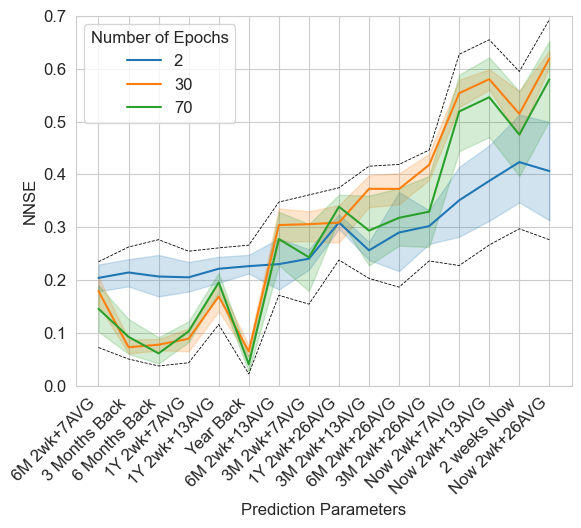

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\4033640831.py:17: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df,


<Figure size 640x480 with 0 Axes>

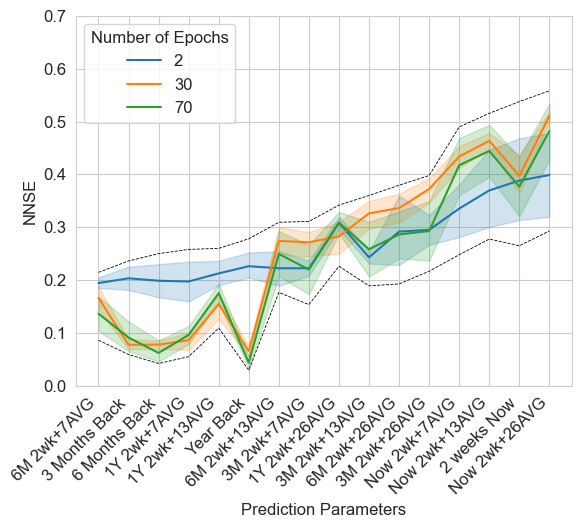

In [52]:
for type_of_df, df in fancy_dict.items():
    plt.clf()
    # df = mega_training_dataframe.pivot(index='name', columns='epoch', values='NNSE')
# df.plot(figsize=(5,3))
    current_order = parameter_order_validation

    fig, ax = plt.subplots()

    df = df.sort_values('NNSE')
    df['name_cat'] = pd.Categorical(
        df['name'],
        categories = current_order,
        ordered = True
    )
    df = df.sort_values('name_cat')
    palette = sns.color_palette("tab10", 6)
    sns.lineplot(data=df,
                 x="name",
                 y="NNSE",
                 hue='epoch',
                 palette=palette)
    sns.lineplot(data=min_max_df_dict[type_of_df],
                 x="name_sorted",
                 y="maximum",
                 color='black',
                 linestyle='dashed',
                 linewidth='0.6')
    sns.lineplot(data=min_max_df_dict[type_of_df],
                 x="name_sorted",
                 y="minimum",
                 color='black',
                 linestyle='dashed',
                 linewidth='0.6')
    # for labels, dfi in mega_training_dataframe.groupby('epoch'):
    #     dfi.plot(ax = ax, x = 'name', y = 'NNSE', label = labels)

    # set the y range
    plt.ylim(0, 0.7)

    ax.legend(title='Number of Epochs')
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label[:-2] for label in labels]

    plt.legend(handles, new_labels, title='Number of Epochs')
    #plt.text(0.77, 0.41, "Dashed black lines represent\nminimum and maximum", horizontalalignment='left', size='medium', color='black')
    # plt.xticks(mega_training_dataframe['index'], mega_training_dataframe['name'])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
             weight='light')

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Prediction Parameters")
    ax.set_ylabel("NNSE")
    # plt.title(type_of_df.capitalize() + ' on ' + name_of_gpu)
    # image_file = Shell.map_filename(f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}-min-max.pdf').path
    # plt.savefig(image_file, bbox_inches='tight')
    # image_file = Shell.map_filename(f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}-min-max.png').path
    # plt.savefig(image_file, bbox_inches='tight')
    SAVEFIG(fig, f'./images/{name_of_gpu}-NNSE-all-epochs-{type_of_df}-min-max')
    plt.show()


In [53]:
# frequency_NNSE = mega_training_dataframe[['NNSE','epoch']]
# frequency_NNSE = frequency_NNSE.reset_index()
#
# frequency_NNSE.drop('index', axis=1, inplace=True)
# display(frequency_NNSE)
# frequency_NNSE.plot(kind='bar', stacked=True, x='NNSE', y='epoch')
# # plt.show()

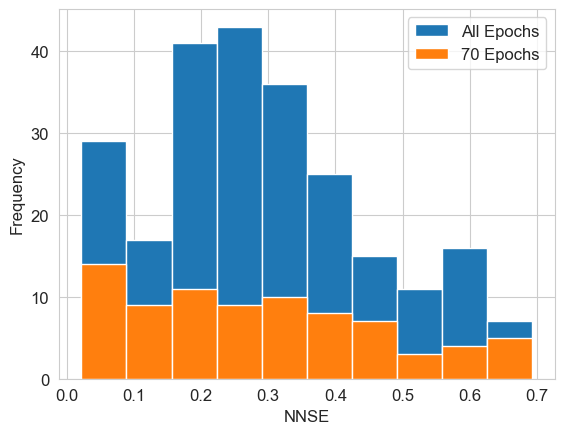

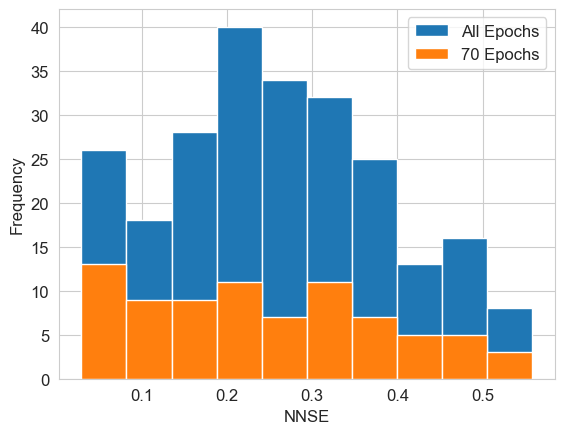

<Figure size 640x480 with 0 Axes>

In [54]:
fancy_dict = {'training': mega_training_dataframe,
              'validation': mega_validation_dataframe}

for type_of_df, df in fancy_dict.items():
    frequency_NNSE = df['NNSE']
    frequency_NNSE_70 = df.loc[df['epoch'] == 70]
    frequency_NNSE_70 = frequency_NNSE_70['NNSE']
    frequency_NNSE.rename("All Epochs", inplace=True)
    frequency_NNSE_70.rename("70 Epochs", inplace=True)
    frequency_NNSE.hist(legend=True)
    frequency_NNSE_70.hist(legend=True)
    plt.ylabel('Frequency')
    plt.xlabel('NNSE')
    # plt.savefig(f'./images/frequency_nnse_histogram_70_{type_of_df}.pdf', bbox_inches='tight')
    # plt.savefig(f'./images/frequency_nnse_histogram_70_{type_of_df}.png', bbox_inches='tight')
    SAVEFIG(plt, f'./images/frequency_nnse_histogram_70_{type_of_df}')
    plt.show()
    plt.clf()
#plt.legend()


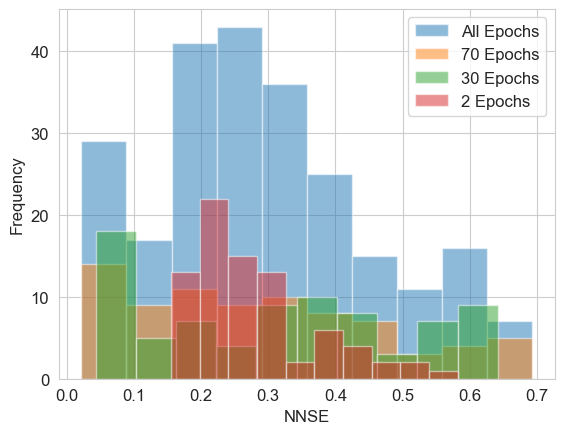

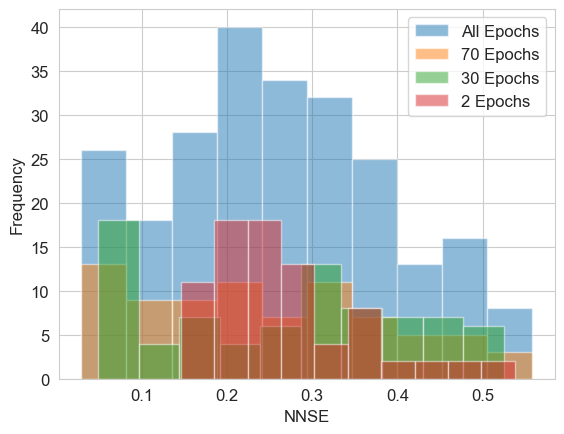

<Figure size 640x480 with 0 Axes>

In [55]:
# stacked bar graph for all epochs
fancy_dict = {'training': mega_training_dataframe,
              'validation': mega_validation_dataframe}

for type_of_df, df in fancy_dict.items():
    frequency_NNSE = df['NNSE']

    frequency_NNSE_70 = df.loc[df['epoch'] == 70]
    frequency_NNSE_70 = frequency_NNSE_70['NNSE']

    frequency_NNSE_30 = df.loc[df['epoch'] == 30]
    frequency_NNSE_30 = frequency_NNSE_30['NNSE']

    frequency_NNSE_2 = df.loc[df['epoch'] == 2]
    frequency_NNSE_2 = frequency_NNSE_2['NNSE']

    frequency_NNSE.rename("All Epochs", inplace=True)
    frequency_NNSE_70.rename("70 Epochs", inplace=True)
    frequency_NNSE_30.rename("30 Epochs", inplace=True)
    frequency_NNSE_2.rename("2 Epochs", inplace=True)
    frequency_NNSE.hist(legend=True, alpha=0.5)
    frequency_NNSE_70.hist(legend=True, alpha=0.5)
    frequency_NNSE_30.hist(legend=True, alpha=0.5)
    frequency_NNSE_2.hist(legend=True, alpha=0.5)

    plt.ylabel('Frequency')
    plt.xlabel('NNSE')
    #plt.savefig(f'./images/frequency_nnse_histogram_70_{type_of_df}.pdf', bbox_inches='tight')
    SAVEFIG(plt, f'./images/frequency_nnse_histogram_70_{type_of_df}')
    plt.show()
    plt.clf()
#plt.legend()


In [56]:
condensed = mega_training_dataframe[['NNSE', 'epoch', 'name']]
condensed.sort_values('NNSE', ascending=True)


condensed = condensed.iloc[::-1]

condensed['epoch'] = condensed['epoch'].astype(int)

two_epoch_two_week_now = condensed
two_epoch_two_week_now = two_epoch_two_week_now.reset_index(drop=True)
two_epoch_two_week_now.index += 1

display(two_epoch_two_week_now)
two_epoch_two_week_now = two_epoch_two_week_now.loc[(two_epoch_two_week_now['epoch'] == 2) & (two_epoch_two_week_now['name'] == '2 weeks Now')]
print('here it is')
display(two_epoch_two_week_now)
print('done')

two_epoch_26_average = condensed
two_epoch_26_average = two_epoch_26_average.reset_index(drop=True)
two_epoch_26_average.index += 1

display(two_epoch_26_average)
two_epoch_26_average = two_epoch_26_average.loc[(two_epoch_26_average['epoch'] == 70) & (two_epoch_26_average['name'] == 'Now 2wk+26AVG')]
print('26avg')
display(two_epoch_26_average)
print('done')

# new_table = two_epoch_two_week_now[two_epoch_two_week_now['NNSE']]
# new_table['rank'] = new_table.index
# print('my describe')
# new_table.describe()
# print('donedescribing')
#
# condensed = condensed.head(20)
#
# condensed = condensed.reset_index(drop=True)
# condensed.index += 1
#display(condensed)
#
# print(condensed.name.unique())
# two_epoch_two_week_now = condensed.loc[(condensed['epoch'] == 2) & (condensed['name'] == '2 weeks Now')]
# print('here it is')
# display(two_epoch_two_week_now)
# print('done')

# condensed.sort_values('NNSE', ascending=True)
# display(condensed)

,NNSE,epoch,name
1,0.6681,70,Now 2wk+26AVG
2,0.6295,70,Now 2wk+13AVG
3,0.6009,70,Now 2wk+7AVG
4,0.5696,70,2 weeks Now
5,0.3797,70,6M 2wk+26AVG
...,...,...,...
236,0.1999,2,3M 2wk+7AVG
237,0.1764,2,3 Months Back
238,0.1709,2,6M 2wk+13AVG
239,0.1639,2,6M 2wk+7AVG


here it is


,NNSE,epoch,name
161,0.5818,2,2 weeks Now
184,0.2969,2,2 weeks Now
195,0.4473,2,2 weeks Now
209,0.4098,2,2 weeks Now
225,0.3800,2,2 weeks Now


done


,NNSE,epoch,name
1,0.6681,70,Now 2wk+26AVG
2,0.6295,70,Now 2wk+13AVG
3,0.6009,70,Now 2wk+7AVG
4,0.5696,70,2 weeks Now
5,0.3797,70,6M 2wk+26AVG
...,...,...,...
236,0.1999,2,3M 2wk+7AVG
237,0.1764,2,3 Months Back
238,0.1709,2,6M 2wk+13AVG
239,0.1639,2,6M 2wk+7AVG


26avg


,NNSE,epoch,name
1,0.6681,70,Now 2wk+26AVG
17,0.6930,70,Now 2wk+26AVG
33,0.4687,70,Now 2wk+26AVG
49,0.5052,70,Now 2wk+26AVG
65,0.5649,70,Now 2wk+26AVG


done


In [57]:
writefile('./tables/best_nnse_values_training.txt', condensed.to_latex())

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2225981459.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  writefile('./tables/best_nnse_values_training.txt', condensed.to_latex())


In [58]:
condensed_2 = mega_validation_dataframe[['NNSE', 'epoch', 'name']]
condensed_2 = condensed_2.sort_values('NNSE')
condensed_2 = condensed_2.iloc[::-1]
#display(condensed_2)

condensed_2['epoch'] = condensed_2['epoch'].astype(int)
print(condensed_2.columns)
display(condensed_2)

two_epoch_two_week_now = condensed_2
two_epoch_two_week_now = two_epoch_two_week_now.reset_index(drop=True)
two_epoch_two_week_now.index += 1

display(two_epoch_two_week_now)
two_epoch_two_week_now = two_epoch_two_week_now.loc[(two_epoch_two_week_now['epoch'] == 2) & (two_epoch_two_week_now['name'] == '2 weeks Now')]
print('here it is')
display(two_epoch_two_week_now)
print('done')

two_epoch_26_average = condensed_2
two_epoch_26_average = two_epoch_26_average.reset_index(drop=True)
two_epoch_26_average.index += 1

display(two_epoch_26_average)
two_epoch_26_average = two_epoch_26_average.loc[(two_epoch_26_average['epoch'] == 70) & (two_epoch_26_average['name'] == 'Now 2wk+26AVG')]
print('26avg')
display(two_epoch_26_average)
print('done')

Index(['NNSE', 'epoch', 'name'], dtype='object')


,NNSE,epoch,name
12,0.5582,70,Now 2wk+26AVG
12,0.5487,70,Now 2wk+26AVG
0,0.5377,2,2 weeks Now
12,0.5292,2,Now 2wk+26AVG
12,0.5246,30,Now 2wk+26AVG
...,...,...,...
2,0.0448,70,6 Months Back
2,0.0417,70,6 Months Back
3,0.0414,70,Year Back
3,0.0310,70,Year Back


,NNSE,epoch,name
1,0.5582,70,Now 2wk+26AVG
2,0.5487,70,Now 2wk+26AVG
3,0.5377,2,2 weeks Now
4,0.5292,2,Now 2wk+26AVG
5,0.5246,30,Now 2wk+26AVG
...,...,...,...
236,0.0448,70,6 Months Back
237,0.0417,70,6 Months Back
238,0.0414,70,Year Back
239,0.0310,70,Year Back


here it is


,NNSE,epoch,name
3,0.5377,2,2 weeks Now
33,0.4221,2,2 weeks Now
55,0.3646,2,2 weeks Now
61,0.3518,2,2 weeks Now
116,0.2647,2,2 weeks Now


done


,NNSE,epoch,name
1,0.5582,70,Now 2wk+26AVG
2,0.5487,70,Now 2wk+26AVG
3,0.5377,2,2 weeks Now
4,0.5292,2,Now 2wk+26AVG
5,0.5246,30,Now 2wk+26AVG
...,...,...,...
236,0.0448,70,6 Months Back
237,0.0417,70,6 Months Back
238,0.0414,70,Year Back
239,0.0310,70,Year Back


26avg


,NNSE,epoch,name
1,0.5582,70,Now 2wk+26AVG
2,0.5487,70,Now 2wk+26AVG
17,0.4675,70,Now 2wk+26AVG
28,0.4386,70,Now 2wk+26AVG
39,0.3977,70,Now 2wk+26AVG


done


In [59]:

condensed_2 = condensed_2.head(20)

condensed_2 = condensed_2.reset_index(drop=True)
condensed_2.index += 1
display(condensed_2)
# condensed_2.sort_values('NNSE', ascending=True)
# display(condensed_2)

,NNSE,epoch,name
1,0.5582,70,Now 2wk+26AVG
2,0.5487,70,Now 2wk+26AVG
3,0.5377,2,2 weeks Now
4,0.5292,2,Now 2wk+26AVG
5,0.5246,30,Now 2wk+26AVG
6,0.5156,70,Now 2wk+13AVG
7,0.5150,30,Now 2wk+26AVG
8,0.5133,30,Now 2wk+26AVG
9,0.5050,70,Now 2wk+13AVG
10,0.5034,30,Now 2wk+26AVG


In [60]:
writefile('./tables/best_nnse_values_validation.txt', condensed_2.to_latex())

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\364815131.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  writefile('./tables/best_nnse_values_validation.txt', condensed_2.to_latex())


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3356928811.py:8: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=mega_validation_dataframe,
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\3356928811.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


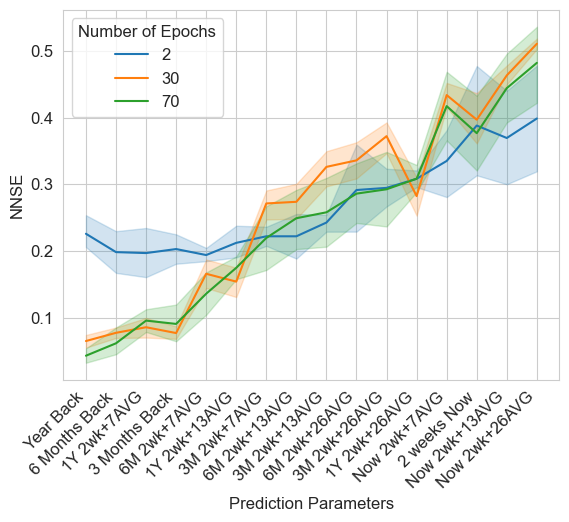

In [61]:
# df = mega_validation_dataframe.pivot(index='name', columns='epoch', values='NNSE')
# df.plot(figsize=(5,3))

fig, ax = plt.subplots()

mega_validation_dataframe = mega_validation_dataframe.sort_values('NNSE')
palette = sns.color_palette("tab10", 6)
sns.lineplot(data=mega_validation_dataframe,
             x="name",
             y="NNSE",
             hue='epoch',
             palette=palette)
# for labels, dfi in mega_validation_dataframe.groupby('epoch'):
#     dfi.plot(ax = ax, x = 'name', y = 'NNSE', label = labels)

ax.legend(title = 'Number of epochs')

handles, labels = ax.get_legend_handles_labels()
new_labels = [label[:-2] for label in labels]

plt.legend(handles, new_labels, title='Number of Epochs')
# plt.xticks(mega_validation_dataframe['index'], mega_validation_dataframe['name'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
         weight='light')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Prediction Parameters")
ax.set_ylabel("NNSE")
# image_file = Shell.map_filename(f'./images/{name_of_gpu}-NNSE-all-epochs-validation.pdf').path
# plt.savefig(image_file, bbox_inches='tight')
SAVEFIG(plt, f'./images/{name_of_gpu}-NNSE-all-epochs-validation')
fig.show()

In [62]:
for labels, dfi in mega_training_dataframe.groupby('epoch'):
    result_training = dfi[['name', 'NNSE']]
    result_training.sort_values('NNSE', inplace=True)
    result_training.rename(columns={'name': 'Name'},
                           inplace=True)
    display(result_training)
    content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
    content.insert(2, '\\hline')
    content.insert(-1, '\\hline')
    table_file = Shell.map_filename(f'./tables/{str(int(labels))}-training-NNSE.tex').path
    # content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
    # content = content.replace('\\\\', '\\\\\\hline', 1)
    writefile(table_file, '\n'.join(content))

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
2,6 Months Back,0.1556
7,1Y 2wk+7AVG,0.1627
6,6M 2wk+7AVG,0.1639
10,6M 2wk+13AVG,0.1709
2,6 Months Back,0.1721
...,...,...
8,Now 2wk+13AVG,0.4541
8,Now 2wk+13AVG,0.4951
12,Now 2wk+26AVG,0.5154
12,Now 2wk+26AVG,0.5311


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
7,1Y 2wk+7AVG,0.0431
3,Year Back,0.0465
1,3 Months Back,0.0577
1,3 Months Back,0.0580
2,6 Months Back,0.0612
...,...,...
8,Now 2wk+13AVG,0.6063
12,Now 2wk+26AVG,0.6101
12,Now 2wk+26AVG,0.6178
12,Now 2wk+26AVG,0.6371


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.0219
3,Year Back,0.0259
2,6 Months Back,0.0371
3,Year Back,0.0386
2,6 Months Back,0.0436
...,...,...
4,Now 2wk+7AVG,0.6274
8,Now 2wk+13AVG,0.6295
8,Now 2wk+13AVG,0.6549
12,Now 2wk+26AVG,0.6681


In [63]:
for labels, dfi in mega_validation_dataframe.groupby('epoch'):
    result_training = dfi[['name', 'NNSE']]
    result_training.sort_values('NNSE', inplace=True)
    result_training.rename(columns={'name': 'Name'},
                           inplace=True)
    display(result_training)
    content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
    content.insert(2, '\\hline')
    content.insert(-1, '\\hline')
    table_file = Shell.map_filename(f'./tables/{str(int(labels))}-validation-NNSE.tex').path
    # content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
    # content = content.replace('\\\\', '\\\\\\hline', 1)
    writefile(table_file, '\n'.join(content))

C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
7,1Y 2wk+7AVG,0.1457
7,1Y 2wk+7AVG,0.1531
2,6 Months Back,0.1614
2,6 Months Back,0.1626
1,3 Months Back,0.1707
...,...,...
8,Now 2wk+13AVG,0.4429
12,Now 2wk+26AVG,0.4594
8,Now 2wk+13AVG,0.4734
12,Now 2wk+26AVG,0.5292


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.0487
7,1Y 2wk+7AVG,0.0547
3,Year Back,0.0640
2,6 Months Back,0.0653
3,Year Back,0.0665
...,...,...
12,Now 2wk+26AVG,0.4975
12,Now 2wk+26AVG,0.5034
12,Now 2wk+26AVG,0.5133
12,Now 2wk+26AVG,0.5150


C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_7812\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.0290
3,Year Back,0.0310
3,Year Back,0.0414
2,6 Months Back,0.0417
2,6 Months Back,0.0448
...,...,...
4,Now 2wk+7AVG,0.4897
8,Now 2wk+13AVG,0.5050
8,Now 2wk+13AVG,0.5156
12,Now 2wk+26AVG,0.5487


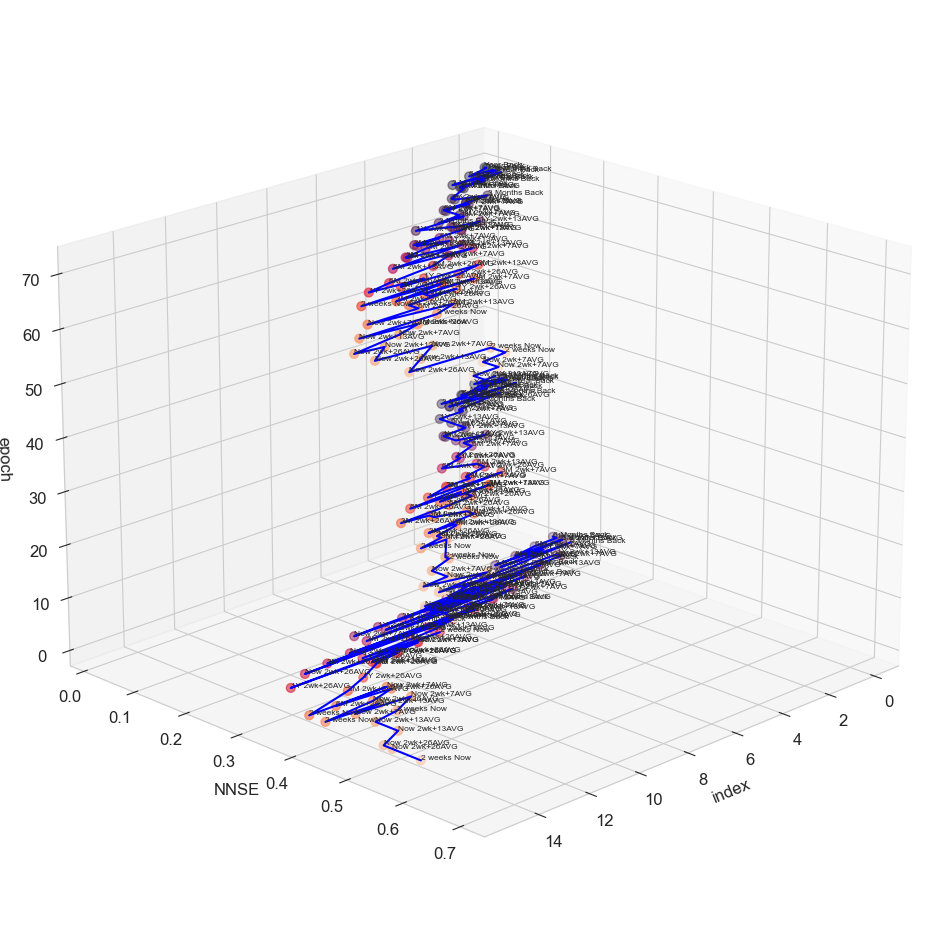

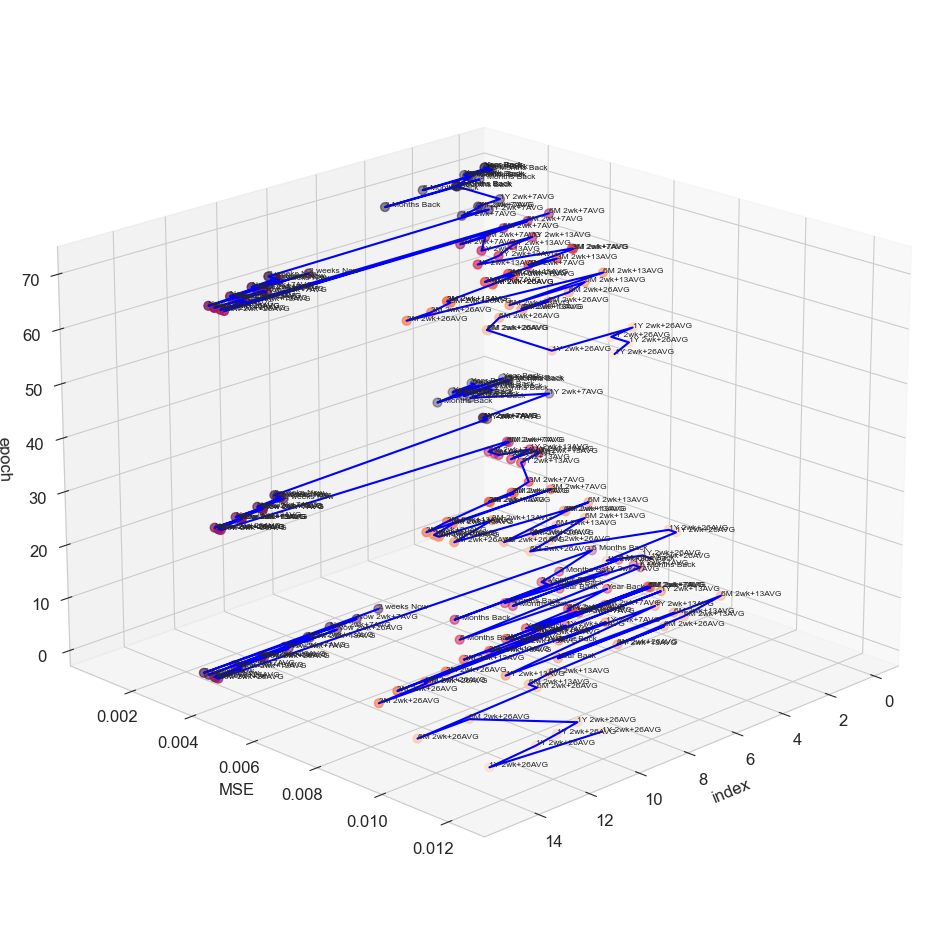

In [64]:
graphs = ['NNSE', 'MSE']
for graph_type in graphs:
    mega_training_dataframe.sort_values(graph_type, inplace=True)
    mega_validation_dataframe.sort_values(graph_type, inplace=True)

    cm = plt.get_cmap("RdYlGn")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('index')
    ax.set_ylabel(graph_type)
    ax.set_zlabel('epoch')
    ax.scatter(mega_training_dataframe['index'],
               mega_training_dataframe[graph_type],
               mega_training_dataframe['epoch'],
               # s=range(len(mega_training_dataframe['epoch'])),
               c=range(len(mega_training_dataframe['epoch'])),
               s=40,
               marker='o')
    for i in range(len(mega_training_dataframe)):
        x, y, z = mega_training_dataframe.iloc[i]['index'], mega_training_dataframe.iloc[i][graph_type], mega_training_dataframe.iloc[i]['epoch']
        ax.text(x, y, z, '{0}'.format(mega_training_dataframe.iloc[i]['name']), rotation=-45, rotation_mode='anchor', size=6)
    for epoch in epochs:
        temp_df = mega_training_dataframe.loc[mega_training_dataframe['epoch'] == float(epoch)]
        ax.plot(
               temp_df['index'], temp_df[graph_type], temp_df['epoch'],  # data
               #color='purple',                            # marker colour
               #marker='o',                                # marker shape
               color='blue'                                       # marker size
               )
    ax.view_init(20, 45)
    plt.show()
    # for idx, row in mega_training_dataframe.iterrows():
    #     ax.annotate(row['2weekIntervals'], (row['index'], row[graph_type], row['epoch']), rotation=0, fontsize=6)


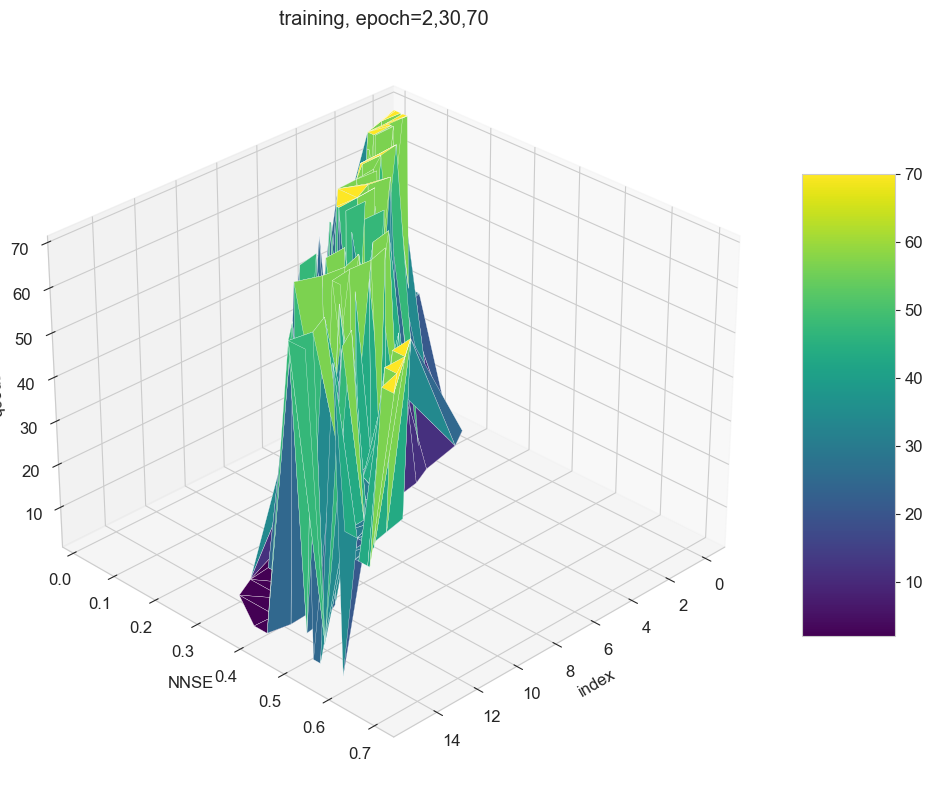

In [65]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
surf=ax.plot_trisurf(mega_training_dataframe['index'],
           mega_training_dataframe['NNSE'],
           mega_training_dataframe['epoch'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('index')
ax.set_ylabel('NNSE')
ax.set_zlabel('epoch')
ax.view_init(30, 45)
plt.title('training, epoch=2,30,70')
plt.show()